# Capstone Project

Analyzing Crime Occurance in Los Angeles From 2010 to Present 


In [1]:
import pandas as pd 
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import rc 
from datetime import datetime as dt 
from matplotlib.font_manager import FontProperties
import seaborn as sns 
import numpy as np
from mapsplotlib import mapsplot as mplt
%matplotlib inline 

In [2]:
# Setting a seaborn style for all graphs 
sns.set()

In [3]:
# Loading the data 
df=pd.read_csv('/Users/dasha/Downloads/Crime_Data_from_2010_to_Present.csv',parse_dates=[['Date Occurred','Time Occurred']])

In [4]:
# Checking the types of variables 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1805537 entries, 0 to 1805536
Data columns (total 25 columns):
Date Occurred_Time Occurred    datetime64[ns]
DR Number                      int64
Date Reported                  object
Area ID                        int64
Area Name                      object
Reporting District             int64
Crime Code                     int64
Crime Code Description         object
MO Codes                       object
Victim Age                     float64
Victim Sex                     object
Victim Descent                 object
Premise Code                   float64
Premise Description            object
Weapon Used Code               float64
Weapon Description             object
Status Code                    object
Status Description             object
Crime Code 1                   float64
Crime Code 2                   float64
Crime Code 3                   float64
Crime Code 4                   float64
Address                        object
Cr

In [5]:
# Dropping unnecessary columns 
df=df.drop(columns=['DR Number','Date Reported','Reporting District','MO Codes','Crime Code','Area ID','Premise Code','Weapon Used Code','Status Code','Crime Code 1','Crime Code 2','Crime Code 3','Crime Code 4','Address','Cross Street'])

In [6]:
# Splitting datatime object into separate date and time columns (For efficient use later...)

df['Date Occurred']=df['Date Occurred_Time Occurred'].dt.date
df['Time Occurred']=df['Date Occurred_Time Occurred'].dt.time
df['Hour']=df['Date Occurred_Time Occurred'].dt.hour
df['Minute']=df['Date Occurred_Time Occurred'].dt.minute
df['Day_of_Month']=df['Date Occurred_Time Occurred'].dt.day 
df['Month']=df['Date Occurred_Time Occurred'].dt.month 

# For machine learning purposes 

df['Hour_sin'] = np.sin(df.Hour*2.*np.pi/24)
df['Hour_cos'] = np.cos(df.Hour*2.*np.pi/24)
df['Min_sin'] = np.sin(df.Minute*2.*np.pi/60*24)
df['Min_cos'] = np.cos(df.Minute*2.*np.pi/60*24)
df['Day_sin']=np.sin(df.Day_of_Month*2.*np.pi/31)
df['Day_cos']=np.cos(df.Day_of_Month*2.*np.pi/31)
df['Month_sin']=np.sin(df.Day_of_Month*2.*np.pi/12)
df['Month_cos']=np.cos(df.Day_of_Month*2.*np.pi/12)

In [7]:
# Building a time classifier column 

morning_start=pd.to_datetime('06:00:00').time()
morning_end=pd.to_datetime('12:00:00').time()
afternoon_end=pd.to_datetime('17:00:00').time()
evening_end=pd.to_datetime('22:00:00').time()

def time_categorizer(time_str):
    
    if (time_str>morning_start) & (time_str<=morning_end):
        return "Morning"
    elif (time_str>morning_end) & (time_str<=afternoon_end):
        return 'Afternoon'
    elif (time_str>afternoon_end) & (time_str<=evening_end):
        return 'Evening'
    else: 
        return 'Night'

df['Time Code']=df['Time Occurred'].apply(time_categorizer)

In [8]:
# Looking at missing values

num_row=df.shape[0]
vic_age=df['Victim Age'].isna().sum()
vic_sex=df['Victim Sex'].isna().sum()
vic_des=df['Victim Descent'].isna().sum()
vic_total=vic_age+vic_sex+vic_des
print(vic_total) 

#NaN of 3 groups comprise approx. 1/4 of total data - will keep the NaN values since 
#some of that data will be useful for other calculations 

476297


In [9]:
df['Victim Age'].fillna('Missing',inplace=True)
df['Victim Sex'].fillna('Missing',inplace=True)
df['Victim Descent'].fillna('Missing',inplace=True)

In [10]:
# How much data is missing in 'Weapoin Description'?
(df['Weapon Description'].isna().sum())/num_row*100

66.70491936747905

In [11]:
# Since the column is missing more than 66% of its data....
df.drop(columns='Weapon Description',inplace=True)

In [12]:
(df['Premise Description'].isna().sum())/num_row*100

0.17933722765027799

In [13]:
# Premise Description data is well populated and could be used in calculations 
# Will drop NaN values since number of missing data is insignificant 

In [14]:
df.dropna(subset=['Premise Description'],how='any',inplace=True)

In [15]:
# Building a broad, but more narrow classification of crime labels than in the original dataframe ....

Crime={'Motor Vehicle and Transportation-Related Crime':['RECKLESS DRIVING',
                                                'DRIVING WITHOUT OWNER CONSENT (DWOC)',
                                                  'FAILURE TO YIELD','TRAIN WRECKING'],
    'Sex-Related Crime':['INTIMATE PARTNER - SIMPLE ASSAULT',
                            'INTIMATE PARTNER - AGGRAVATED ASSAULT',
                            'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH 0007=02',
                            'INDECENT EXPOSURE',
                            'RAPE, FORCIBLE',
                            'SEXUAL PENTRATION WITH A FOREIGN OBJECT',
                            'LETTERS, LEWD',
                            'RAPE, ATTEMPTED',
                            'LEWD CONDUCT',
                            'BATTERY WITH SEXUAL CONTACT',
                            'PIMPING',
                            'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM0065',
                            'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM',
                            'PEEPING TOM',
                            'SEX, UNLAWFUL',
                            'ORAL COPULATION',
                            'PANDERING',
                            'INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)',
                            'SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ0059',
                            'SEXUAL PENETRATION W/FOREIGN OBJECT',
                            'LEWD/LASCIVIOUS ACTS WITH CHILD',
                            'SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ',
                            'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD',
                            'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH','BIGAMY'],
    'Human Trafficking':['HUMAN TRAFFICKING - COMMERCIAL SEX ACTS',
                            'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE'],
    'Vandalism and Property Damage':['VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
                                        'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
                                        'TELEPHONE PROPERTY - DAMAGE',
                                        'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) 0114'],
    'Kidnapping':['KIDNAPPING',
                     'CHILD STEALING',
                     'KIDNAPPING - GRAND ATTEMPT'],
    'Criminal Threats':['CRIMINAL THREATS - NO WEAPON DISPLAYED',
                           'STALKING','BOMB SCARE','BRANDISH WEAPON',
                           'THREATENING PHONE CALLS/LETTERS'],
    'Homocide':['CRIMINAL HOMICIDE',
                   'LYNCHING - ATTEMPTED',
                   'LYNCHING',
                   'MANSLAUGHTER, NEGLIGENT'],
    'Robbery and Theft':['THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
                            'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)',
                            'THEFT PLAIN - PETTY ($950 & UNDER)',
                            'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
                            'BIKE - STOLEN',
                            'ROBBERY',
                            'ATTEMPTED ROBBERY',
                            'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD0036',
                            'BURGLARY FROM VEHICLE',
                            'BURGLARY','SHOPLIFTING-GRAND THEFT ($950.01 & OVER)',
                            'THEFT, PERSON',
                            'EXTORTION',
                            'BURGLARY FROM VEHICLE, ATTEMPTED',
                            'THEFT PLAIN - ATTEMPT',
                            'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
                            'BURGLARY, ATTEMPTED',
                            'THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)',
                            'THEFT OF IDENTITY',
                            'BUNCO, GRAND THEFT',
                            'PURSE SNATCHING',
                            'PROWLER',
                            'VEHICLE - ATTEMPT STOLEN',
                            'BIKE - ATTEMPTED STOLEN',
                            'THEFT FROM PERSON - ATTEMPT',
                            'PICKPOCKET',
                            'VEHICLE - STOLEN','DISHONEST EMPLOYEE - PETTY THEFT',
                            'BUNCO, ATTEMPT',
                            'BUNCO, PETTY THEFT',
                            'SHOPLIFTING - ATTEMPT',
                            'PICKPOCKET, ATTEMPT',
                            'PURSE SNATCHING - ATTEMPT',
                            'THEFT FROM MOTOR VEHICLE - ATTEMPT',
                            'DISHONEST EMPLOYEE - GRAND THEFT',
                            'THEFT, COIN MACHINE - PETTY ($950 & UNDER)',
                            'BOAT - STOLEN','TILL TAP - PETTY ($950 & UNDER)',
                            'THEFT, COIN MACHINE - GRAND ($950.01 & OVER)',
                            'GRAND THEFT / AUTO REPAIR',
                            'PETTY THEFT - AUTO REPAIR',
                            'TILL TAP - ATTEMPT',
                            'TILL TAP - GRAND THEFT ($950.01 & OVER)',
                            'DRUNK ROLL - ATTEMPT','THEFT, COIN MACHINE - ATTEMPT',
                            'DISHONEST EMPLOYEE ATTEMPTED THEFT','DRUNK ROLL','EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)'],
    'Fraud and Bribery':['COUNTERFEIT','DEFRAUDING INNKEEPER/THEFT OF SERVICES, $400 & UNDER',
                         'CREDIT CARDS, FRAUD USE ($950.01 & OVER)',
                         'CREDIT CARDS, FRAUD USE ($950 & UNDER',
                         'DOCUMENT WORTHLESS ($200.01 & OVER)',
                         'BRIBERY',
                         'DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $400',
                         'GRAND THEFT / INSURANCE FRAUD','DOCUMENT WORTHLESS ($200 & UNDER)',
                         'DOCUMENT FORGERY / STOLEN FELONY'],
    'Assault':['BATTERY - SIMPLE ASSAULT',
               'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
               'OTHER ASSAULT',
               'INTIMATE PARTNER - AGGRAVATED ASSAULT',
               'SHOTS FIRED AT INHABITED DWELLING',
               'BATTERY POLICE (SIMPLE)',
               'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER',
               'BATTERY ON A FIREFIGHTER',
               'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT',
               'THROWING OBJECT AT MOVING VEHICLE','DISCHARGE FIREARMS/SHOTS FIRED'],
    'Violation of Orders or Resisting Arrest':['RESISTING ARREST',
                                               'VIOLATION OF COURT ORDER',
                                               'VIOLATION OF RESTRAINING ORDER',
                                               'VIOLATION OF TEMPORARY RESTRAINING ORDER',
                                               'FIREARMS RESTRAINING ORDER (FIREARMS RO)',
                                               'CONTEMPT OF COURT'],
    'Other':['OTHER MISCELLANEOUS CRIME',
             'DISTURBING THE PEACE',
             'CRUELTY TO ANIMALS',
            'UNAUTHORIZED COMPUTER ACCESS',
             'ILLEGAL DUMPING',
             'FALSE POLICE REPORT',
             'CONTRIBUTING',
             'DISRUPT SCHOOL',
             'BLOCKING DOOR INDUCTION CENTER',
             'TRESPASSING',
             'nan',
             'FALSE IMPRISONMENT',
             'CONSPIRACY',
            'ABORTION/ILLEGAL',
            'ARSON'], 
    'Weapon possession/Bombing':['WEAPONS POSSESSION/BOMBING'],
    'Riots and Disruption of Peace':['INCITING A RIOT', 
                                        'FAILURE TO DISPERSE'],
    'Child-Related Crime':['CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT',
                           'CHILD NEGLECT (SEE 300 W.I.C.)',
                           'CHILD ANNOYING (17YRS & UNDER)',
                           'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)0060',
                           'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT',
                           'CHILD ABANDONMENT','CHILD PORNOGRAPHY',
                           'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)'],
    'Unlawful Sales':['DRUGS, TO A MINOR','REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)0132',
                      'REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)']}

In [16]:
# Building a even more narrow classification for crime labels (compared to above)...

crime_detailed={'Reckless Driving':['RECKLESS DRIVING',
                                    'FAILURE TO YIELD',
                                    'TRAIN WRECKING'],
                'Driving Without Owner Consent':['DRIVING WITHOUT OWNER CONSENT (DWOC)'],
                'Rape and Sexual Assault/Battery':['INTIMATE PARTNER - SIMPLE ASSAULT',
                                                   'INTIMATE PARTNER - AGGRAVATED ASSAULT',
                                                   'BATTERY WITH SEXUAL CONTACT',
                                                   'RAPE, ATTEMPTED',
                                                   'RAPE, FORCIBLE'],
                'Sodomy':['SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH 0007=02',
                          'ORAL COPULATION',
                          'SEXUAL PENTRATION WITH A FOREIGN OBJECT',
                          'SEXUAL PENETRATION W/FOREIGN OBJECT',
                          'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH'],
                'Indecency/Lewd Conduct':['INDECENT EXPOSURE',
                                          'LETTERS, LEWD',
                                          'LEWD CONDUCT',
                                          'PEEPING TOM',
                                          'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD'],
                'Prostitution':['PIMPING'],
                'Unlawful Sex':['SEX, UNLAWFUL',
                                'SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ0059',
                                'SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ'],
                'Other Sexual Crime':['BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM0065',
                                      'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM',
                                      'PANDERING',
                                      'INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)','BIGAMY'], 
                'Human Trafficking':['HUMAN TRAFFICKING - COMMERCIAL SEX ACTS',
                                     'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE'],
                'Vandalism and Property Damage':['VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
                                                 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
                                                 'TELEPHONE PROPERTY - DAMAGE',
                                                 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) 0114'],
                'Kidnapping':['KIDNAPPING',
                              'CHILD STEALING',
                              'KIDNAPPING - GRAND ATTEMPT'],
                'Criminal Threats w/o Weapon':['CRIMINAL THREATS - NO WEAPON DISPLAYED'],
                'Criminal Threats w/Weapon':['BRANDISH WEAPON'],
                'Harassment':['STALKING',
                              'THREATENING PHONE CALLS/LETTERS'],
                'Homocide':['CRIMINAL HOMICIDE',
                            'LYNCHING - ATTEMPTED',
                            'LYNCHING',
                            'MANSLAUGHTER, NEGLIGENT'],
                'Theft From a Person':['THEFT, PERSON','THEFT FROM PERSON - ATTEMPT'],
                'Shoplifting':['SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
                               'SHOPLIFTING - ATTEMPT',
                               'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)'],
                'Theft/Burglary From a Vehicle':['THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)',
                                                 'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
                                                 'THEFT FROM MOTOR VEHICLE - ATTEMPT',
                                                 'BURGLARY FROM VEHICLE',
                                                 'BURGLARY FROM VEHICLE, ATTEMPTED'],
                'Petty Theft':['THEFT PLAIN - PETTY ($950 & UNDER)',
                                       'THEFT PLAIN - ATTEMPT',
                                       'THEFT, COIN MACHINE - PETTY ($950 & UNDER)',
                                       'PETTY THEFT - AUTO REPAIR',
                                       'EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)',
                                       'DISHONEST EMPLOYEE ATTEMPTED THEFT',
                                       'THEFT, COIN MACHINE - ATTEMPT',
                                       'TILL TAP - ATTEMPT',
                                       'DISHONEST EMPLOYEE - PETTY THEFT',
                                       'TILL TAP - PETTY ($950 & UNDER)',
                                       'BUNCO, PETTY THEFT',
                                       'BUNCO, ATTEMPT'],
                'Grand Theft':['THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
                                       'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)',
                                       'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD0036',
                                       'TILL TAP - GRAND THEFT ($950.01 & OVER)',
                                       'BUNCO, GRAND THEFT',
                                       'DISHONEST EMPLOYEE - GRAND THEFT',
                                       'GRAND THEFT / AUTO REPAIR',
                                       'THEFT, COIN MACHINE - GRAND ($950.01 & OVER)'],
                'Vehicle/Transportation Theft':['BIKE - STOLEN',
                                                'VEHICLE - STOLEN',
                                                'BOAT - STOLEN',
                                                'BIKE - ATTEMPTED STOLEN',
                                                'VEHICLE - ATTEMPT STOLEN'],
                'Robbery':['ROBBERY','ATTEMPTED ROBBERY'],
                'Burglary':['BURGLARY, ATTEMPTED','BURGLARY'],
                'Pickpocketing/Purse Snatching': ['PICKPOCKET',
                                                  'PICKPOCKET, ATTEMPT',
                                                  'PURSE SNATCHING - ATTEMPT',
                                                  'PURSE SNATCHING',
                                                  'DRUNK ROLL - ATTEMPT',
                                                  'DRUNK ROLL'],
                'Other Theft':['EXTORTION',
                               'PROWLER'],
                'Fraud':['DEFRAUDING INNKEEPER/THEFT OF SERVICES, $400 & UNDER',
                                 'DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $400',
                                 'GRAND THEFT / INSURANCE FRAUD',
                                 'CREDIT CARDS, FRAUD USE ($950.01 & OVER)',
                                 'CREDIT CARDS, FRAUD USE ($950 & UNDER',
                                 'BRIBERY'],
                'Identity Theft': ['THEFT OF IDENTITY'],
                'Forgery and Counterfeit':['COUNTERFEIT',
                                           'DOCUMENT WORTHLESS ($200.01 & OVER)',
                                           'DOCUMENT WORTHLESS ($200 & UNDER)',
                                           'DOCUMENT FORGERY / STOLEN FELONY'],
                'Battery and Simple Assault':['BATTERY - SIMPLE ASSAULT',
                                              'BATTERY POLICE (SIMPLE)',
                                              'BATTERY ON A FIREFIGHTER',
                                              'THROWING OBJECT AT MOVING VEHICLE'],
                'Other Assault':['OTHER ASSAULT'],
                'Assault w/Deadly Weapon':['ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
                                           'SHOTS FIRED AT INHABITED DWELLING',
                                           'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER',
                                           'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT',
                                           'DISCHARGE FIREARMS/SHOTS FIRED'],
                'Violation of Court Orders/Resisting Arrest':['RESISTING ARREST',
                                                              'VIOLATION OF COURT ORDER',
                                                              'VIOLATION OF RESTRAINING ORDER',
                                                              'VIOLATION OF TEMPORARY RESTRAINING ORDER',
                                                              'FIREARMS RESTRAINING ORDER (FIREARMS RO)',
                                                              'CONTEMPT OF COURT'],
                'Trespassing':['TRESPASSING'],
                'Other':['OTHER MISCELLANEOUS CRIME',
                         'CRUELTY TO ANIMALS','UNAUTHORIZED COMPUTER ACCESS','ILLEGAL DUMPING','FALSE POLICE REPORT',
                         'CONTRIBUTING',
                         'DISRUPT SCHOOL',
                         'FALSE IMPRISONMENT',
                         'BLOCKING DOOR INDUCTION CENTER',
                         'nan',
                         'ARSON',
                         'CONSPIRACY',
                         'ABORTION/ILLEGAL'],
                'Riots and Disruption of Peace':['DISTURBING THE PEACE',
                                                 'FAILURE TO DISPERSE',
                                                 'INCITING A RIOT'],
                'Weapon possession/Bombing':['WEAPONS POSSESSION/BOMBING',
                                             'BOMB SCARE'],
                'Physical Child Abuse': ['CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT',
                                         'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT'], 
                'Child Neglect and Abandonment':['CHILD NEGLECT (SEE 300 W.I.C.)',
                                                 'CHILD ABANDONMENT'],
                'Child Sexual Abuse':['CHILD PORNOGRAPHY',
                                      'LEWD/LASCIVIOUS ACTS WITH CHILD'],
                'Other Child Abuse':['CHILD ANNOYING (17YRS & UNDER)',
                                     'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)0060',
                                     'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)'],
                'Unlawful Sales of Drugs and Weapons':['DRUGS, TO A MINOR',
                                                       'REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)0132',
                                                       'REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)']}

In [17]:
# Reverse the dictionary to identify each crime as a subset of broad crimes 

reverse_crime={val: key for key in Crime for val in Crime[key]}

In [18]:
# same as above for the narrow dictionary 

reverse_detailed_crime={val: key for key in crime_detailed for val in crime_detailed[key]}

In [19]:
df['Crime Code Description']=df['Crime Code Description'].astype('str')

In [20]:
# Creating a new column from a broad dictionary 

df['Crime']=df['Crime Code Description'].map(reverse_crime)

In [21]:
# Creating a new column from a narrow dictionary 

df['Crime_Detailed']=df['Crime Code Description'].map(reverse_detailed_crime)

In [22]:
# Replace a difficult name in 'Premise Description'

df['Premise Description']=df['Premise Description'].replace({'MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)':'MULTI-UNIT DWELLING'})

In [23]:
# Asserting if 'Crime' column does not contain any NaNs 

df['Crime'].notnull().all().all()

True

In [24]:
# Asserting if the whole data frame does not contain any NaNs 
df.notnull().all().all()

True

In [25]:
df.head()

Date Occurred_Time Occurred    Area Name  \
0         2013-03-11 18:00:00  77th Street   
1         2010-01-22 23:00:00      Olympic   
2         2013-03-18 20:30:00    Southeast   
3         2010-11-10 18:00:00    Southeast   
4         2014-01-04 23:00:00      Topanga   

                     Crime Code Description Victim Age Victim Sex  \
0         INTIMATE PARTNER - SIMPLE ASSAULT         30          F   
1                          VEHICLE - STOLEN    Missing    Missing   
2                          VEHICLE - STOLEN         12    Missing   
3                          VEHICLE - STOLEN    Missing    Missing   
4  VANDALISM - MISDEAMEANOR ($399 OR UNDER)         84          M   

  Victim Descent     Premise Description Status Description  \
0              W     MULTI-UNIT DWELLING        Adult Other   
1        Missing                  STREET        Invest Cont   
2        Missing                  STREET        Invest Cont   
3        Missing                  STREET        Invest Cont   
4              W  SINGLE FAMILY DWELLING        Invest Cont   

              Location  Date Occurred               ...                 \
0  (33.9829, -118.3338)    2013-03-11               ...                  
1  (34.0454, -118.3157)    2010-01-22               ...                  
2   (33.942, -118.2717)    2013-03-18               ...                  
3  (33.9572, -118.2717)    2010-11-10               ...                  
4  (34.2009, -118.6369)    2014-01-04               ...                  

       Hour_cos       Min_sin  Min_cos   Day_sin   Day_cos     Month_sin  \
0 -1.836970e-16  0.000000e+00      1.0  0.790776 -0.612106 -5.000000e-01   
1  9.659258e-01  0.000000e+00      1.0 -0.968077 -0.250653 -8.660254e-01   
2  5.000000e-01 -1.715001e-14      1.0 -0.485302 -0.874347  3.673940e-16   
3 -1.836970e-16  0.000000e+00      1.0  0.897805 -0.440394 -8.660254e-01   
4  9.659258e-01  0.000000e+00      1.0  0.724793  0.688967  8.660254e-01   

   Month_cos  Time Code                          Crime  \
0   0.866025    Evening              Sex-Related Crime   
1   0.500000      Night              Robbery and Theft   
2  -1.000000    Evening              Robbery and Theft   
3   0.500000    Evening              Robbery and Theft   
4  -0.500000      Night  Vandalism and Property Damage   

                    Crime_Detailed  
0  Rape and Sexual Assault/Battery  
1     Vehicle/Transportation Theft  
2     Vehicle/Transportation Theft  
3     Vehicle/Transportation Theft  
4    Vandalism and Property Damage  

[5 rows x 26 columns]

In [26]:
# Create a dataframe with separate column for the year of crime occurrance 
timed_data=df.loc[:,['Date Occurred_Time Occurred','Area Name','Crime']]
timed_data['Year']=timed_data['Date Occurred_Time Occurred'].dt.year

In [27]:
#Yearly data....

In [28]:
yearly_data=timed_data.drop(columns='Date Occurred_Time Occurred')
# Excluding 2018 since it does not contain full data yet 
yearly_data=yearly_data[yearly_data['Year']!=2018]
yearly_data=yearly_data.groupby(['Year','Area Name']).count()

In [29]:
yearly_data['Crime Count']=yearly_data['Crime']
yearly_data=yearly_data.drop(columns='Crime')

In [30]:
yearly_data=yearly_data.unstack(level='Area Name')

Text(0.5,1,'LA Crime Rate by District')

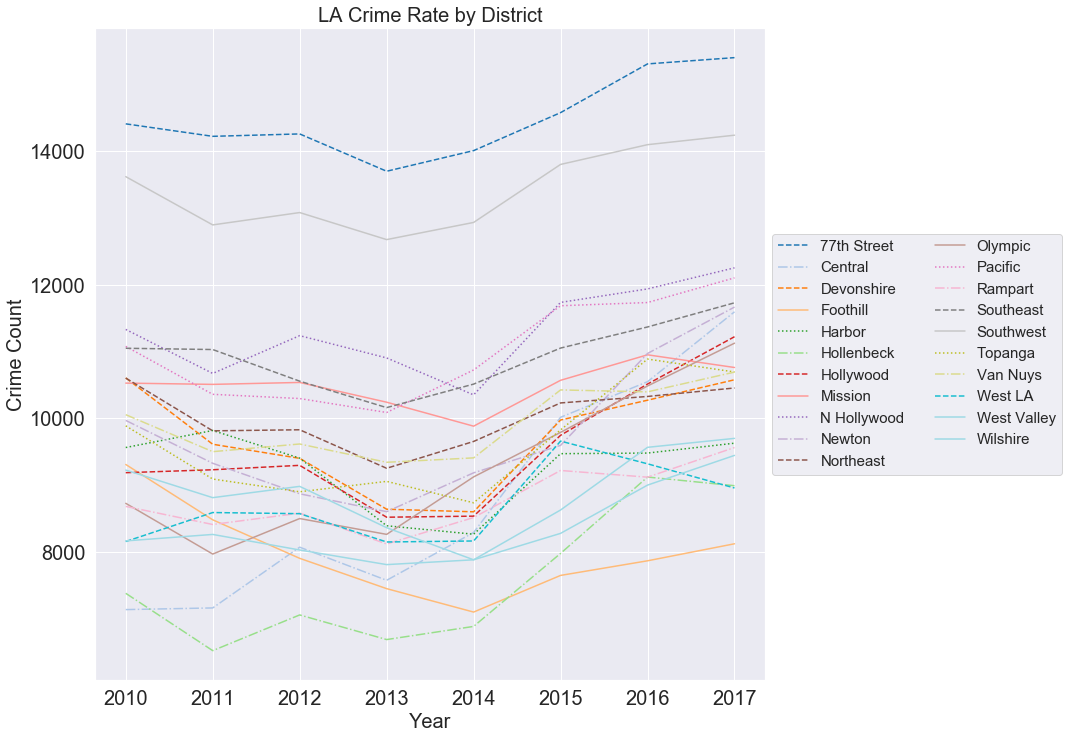

In [31]:
plot=yearly_data['Crime Count'].plot(by='Area Name',style=['--','-.','--','-',':','-.','--','-',':','-.','--','-',':','-.','--','-',':','-.','--','-','-',':','-.','--'],colormap='tab20',figsize=(12,12))
plot.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 15}, ncol=2,facecolor='inherit')
plt.ylabel('Crime Count',fontsize=20)
plt.xlabel('Year',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('LA Crime Rate by District',fontsize=20)


In [32]:
# Seems that 77th Street and Southwest districts are the most dangerous 

In [33]:
# Hollenbeck, Central, Olympic and Newton Districts have rapid increases in crime 

Text(0.5,1,'Regions With Increasing and Decreasing Crime')

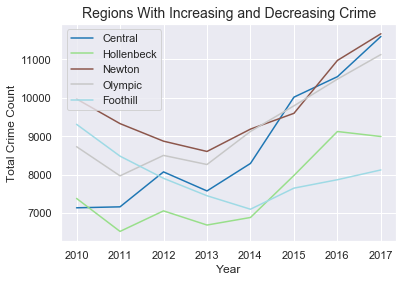

In [34]:
yearly_data['Crime Count'].plot(y=['Central','Hollenbeck','Newton','Olympic','Foothill'],colormap='tab20')
plt.legend(loc='upper left')
plt.xlabel('Year',fontsize=12)
plt.ylabel("Total Crime Count",fontsize=12)
plt.title('Regions With Increasing and Decreasing Crime',fontsize=14)

In [35]:
yearly_bycrime=timed_data.drop(columns='Date Occurred_Time Occurred')
yearly_bycrime=yearly_bycrime[yearly_bycrime['Year']!=2018]

In [36]:
yearly_bycrime=yearly_bycrime.groupby(['Year','Area Name','Crime']).size().to_frame(name='Count')

In [37]:
central_mostcommon=yearly_bycrime.loc[(slice(None),'Central'),:]
central_mostcommon=central_mostcommon.reset_index()
central_mostcommon=central_mostcommon.loc[:,['Year','Crime','Count']]
central_mostcommon.set_index(['Year','Crime'],inplace=True)
central_mostcommon=central_mostcommon.unstack(level='Crime',fill_value=0)

In [38]:
hollenbeck_mostcommon=yearly_bycrime.loc[(slice(None),'Hollenbeck'),:]
hollenbeck_mostcommon=hollenbeck_mostcommon.reset_index()
hollenbeck_mostcommon=hollenbeck_mostcommon.loc[:,['Year','Crime','Count']]
hollenbeck_mostcommon.set_index(['Year','Crime'],inplace=True)
hollenbeck_mostcommon=hollenbeck_mostcommon.unstack(level='Crime',fill_value=0)

In [39]:
newton_mostcommon=yearly_bycrime.loc[(slice(None),'Newton'),:]
newton_mostcommon=newton_mostcommon.reset_index()
newton_mostcommon=newton_mostcommon.loc[:,['Year','Crime','Count']]
newton_mostcommon.set_index(['Year','Crime'],inplace=True)
newton_mostcommon=newton_mostcommon.unstack(level='Crime',fill_value=0)

In [40]:
olympic_mostcommon=yearly_bycrime.loc[(slice(None),'Olympic'),:]
olympic_mostcommon=olympic_mostcommon.reset_index()
olympic_mostcommon=olympic_mostcommon.loc[:,['Year','Crime','Count']]
olympic_mostcommon.set_index(['Year','Crime'],inplace=True)
olympic_mostcommon=olympic_mostcommon.unstack(level='Crime',fill_value=0)

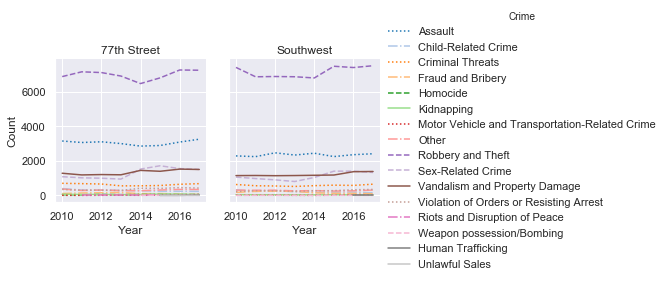

In [41]:
most_dangerous=yearly_bycrime.reset_index()
most_dangerous.set_index(['Area Name'],inplace=True)
most_dangerous=most_dangerous.loc[['77th Street','Southwest']]
most_dangerous.reset_index(inplace=True)
g = sns.FacetGrid(most_dangerous, col="Area Name", hue="Crime",palette='tab20',hue_kws={'ls':[':','-.',':','-.','--','-',':','-.','--','--','-',':','-.','--','-','-',':']})
g.map(plt.plot, "Year", "Count")
g.add_legend()
g.set_titles("{col_name}")

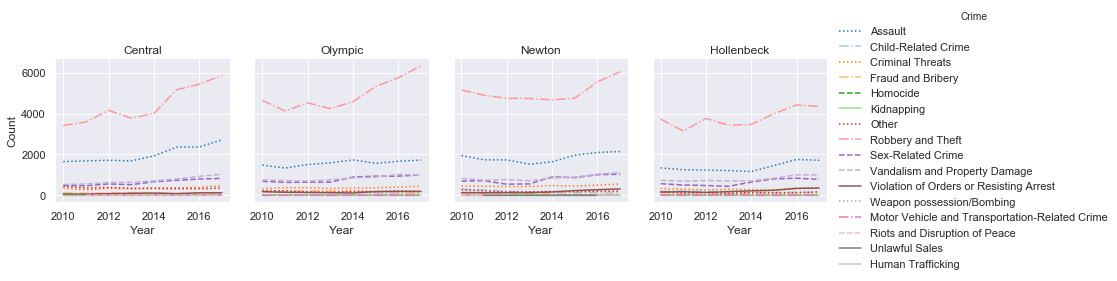

In [42]:
risingc_dist=yearly_bycrime.reset_index()
risingc_dist.set_index(['Area Name'],inplace=True)
risingc_dist=risingc_dist.loc[['Central','Olympic','Newton','Hollenbeck']]
risingc_dist.reset_index(inplace=True)
g = sns.FacetGrid(risingc_dist, col="Area Name", hue="Crime",palette='tab20',hue_kws={'ls':[':','-.',':','-.','--','-',':','-.','--','--','-',':','-.','--','-','-',':']})
g.map(plt.plot, "Year", "Count")
g.add_legend()
g.set_titles("{col_name}")

Text(0.5,1,'Crime Count by Premise')

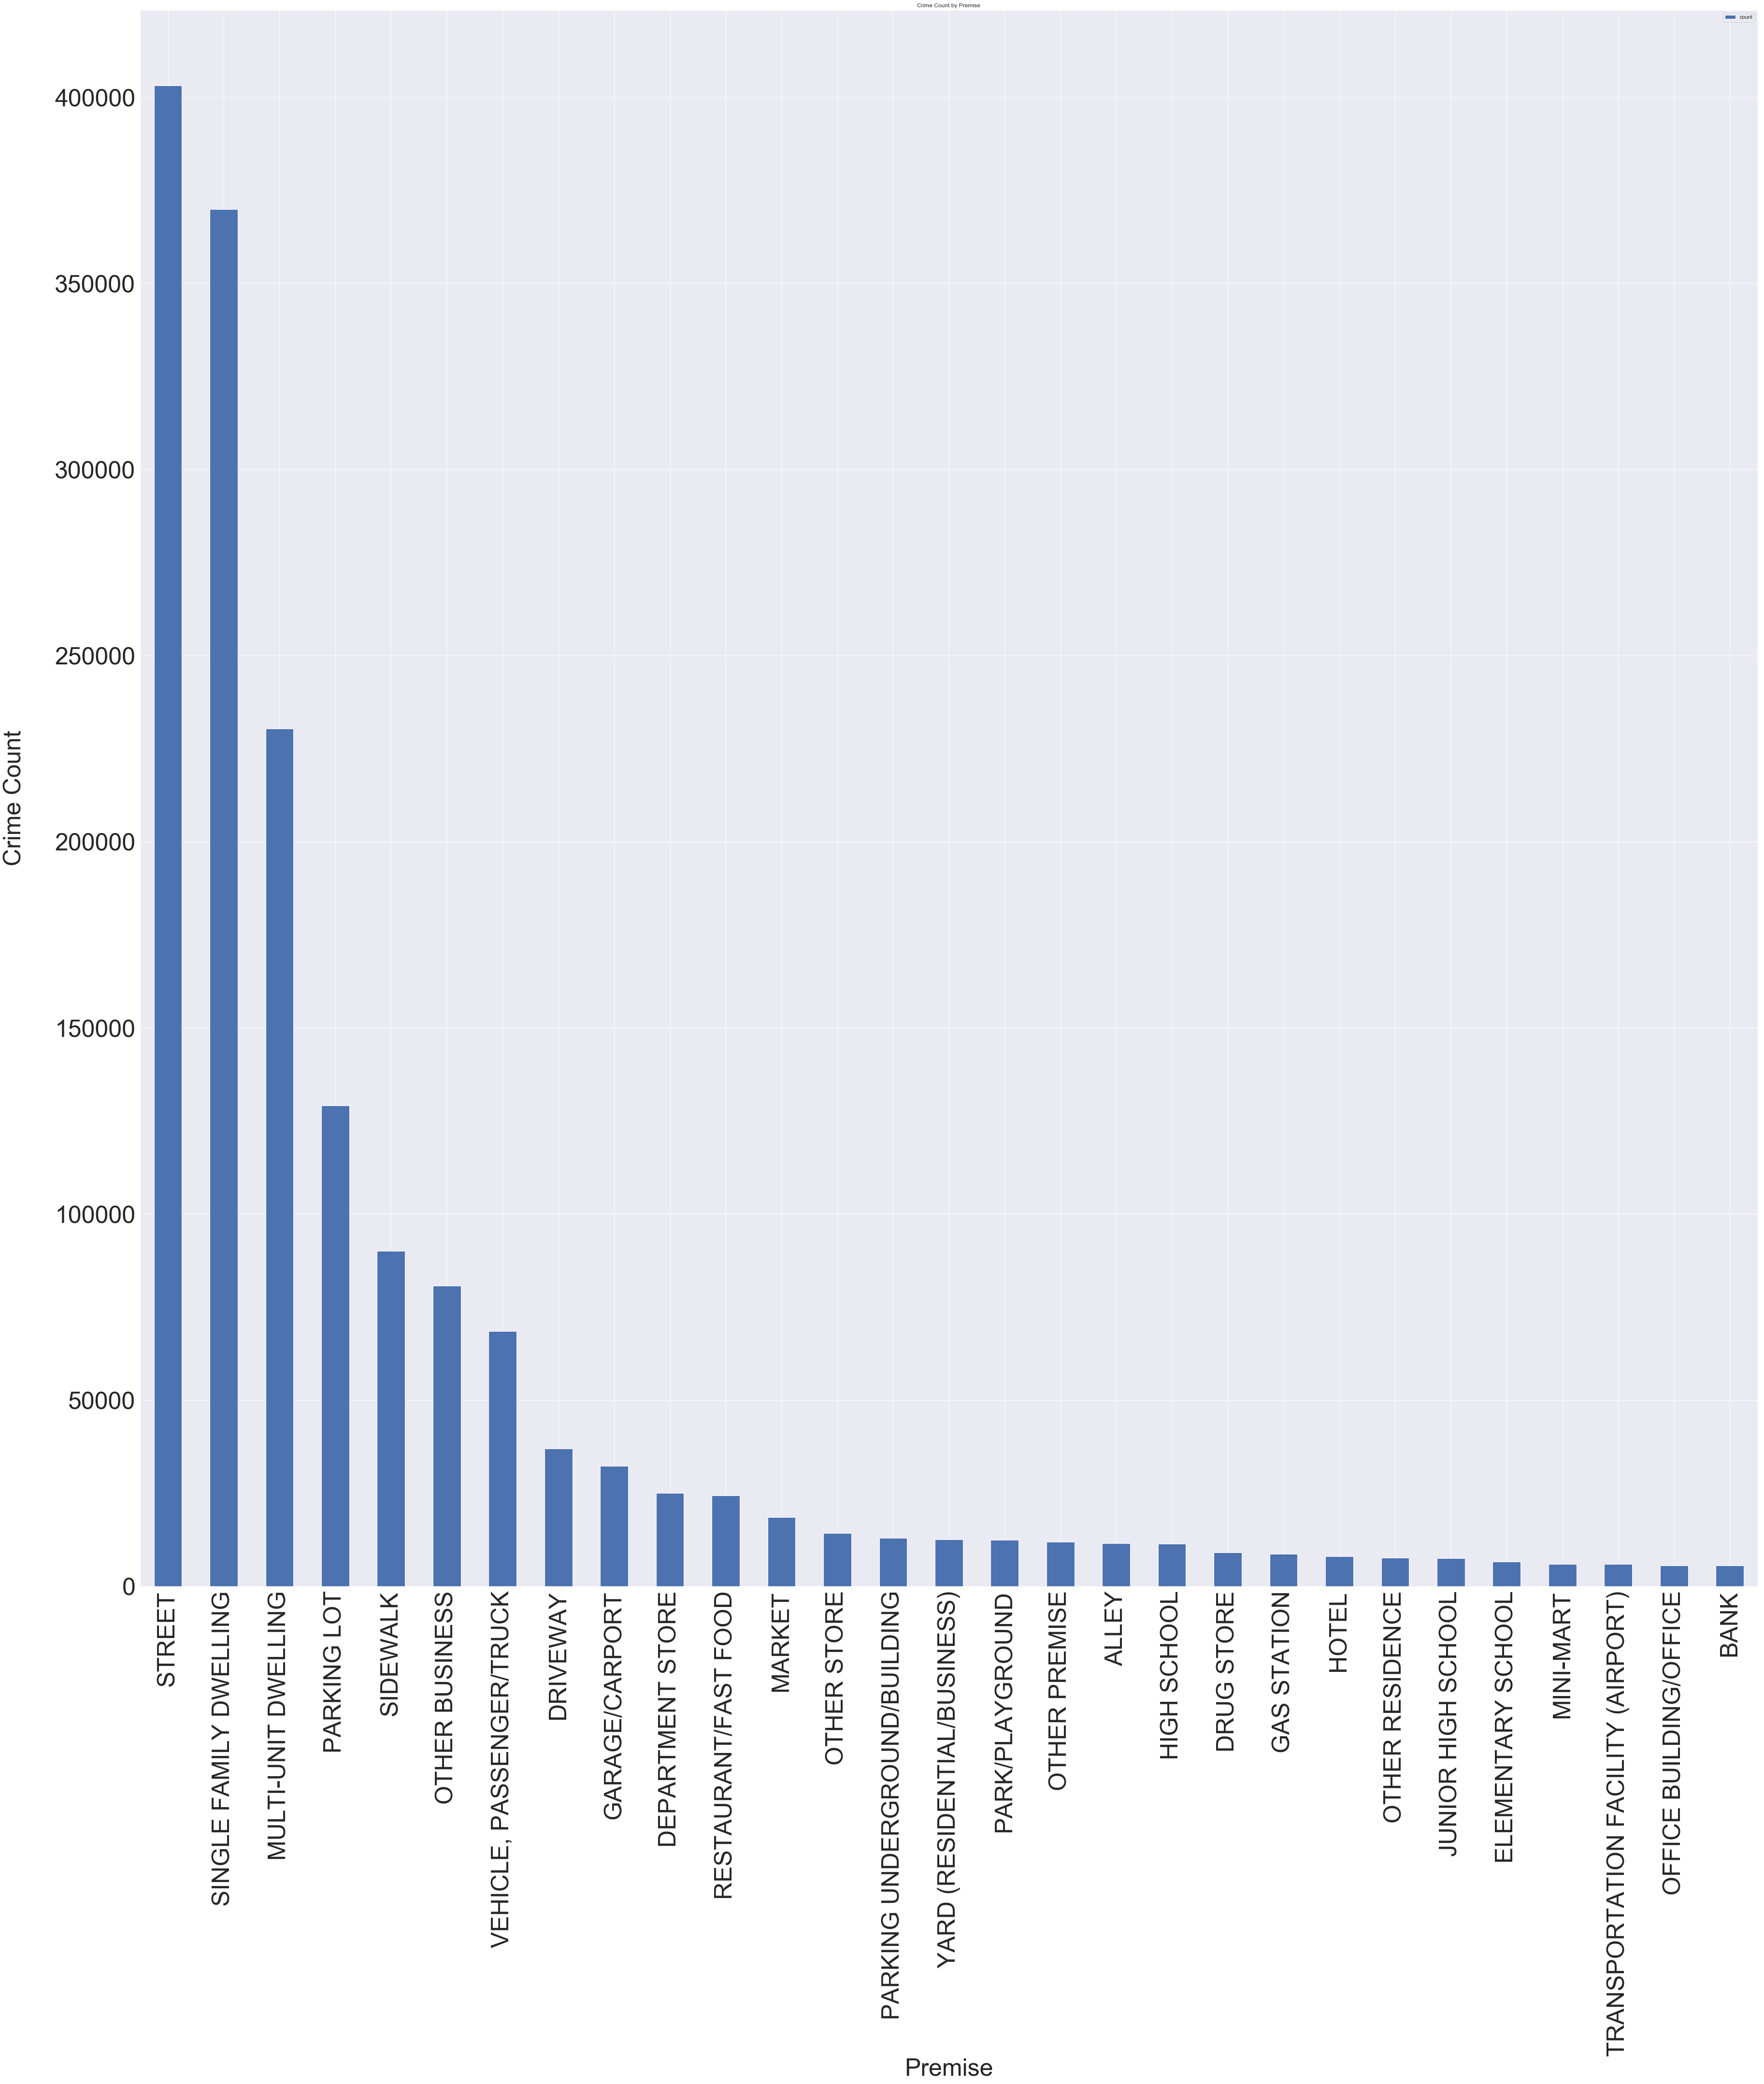

In [43]:
df_premise=df.loc[:,'Premise Description']
df_premise=df_premise.value_counts().to_frame('count')
df_premise=df_premise[df_premise['count']>5000]
df_premise.plot(kind='bar',figsize=(60,60))
plt.xlabel('Premise',fontsize=50)
plt.xticks(fontsize=50)
plt.ylabel('Crime Count',fontsize=50,labelpad=60)
plt.yticks(fontsize=50)
plt.title('Crime Count by Premise')

Text(0.5,0,'Premise')

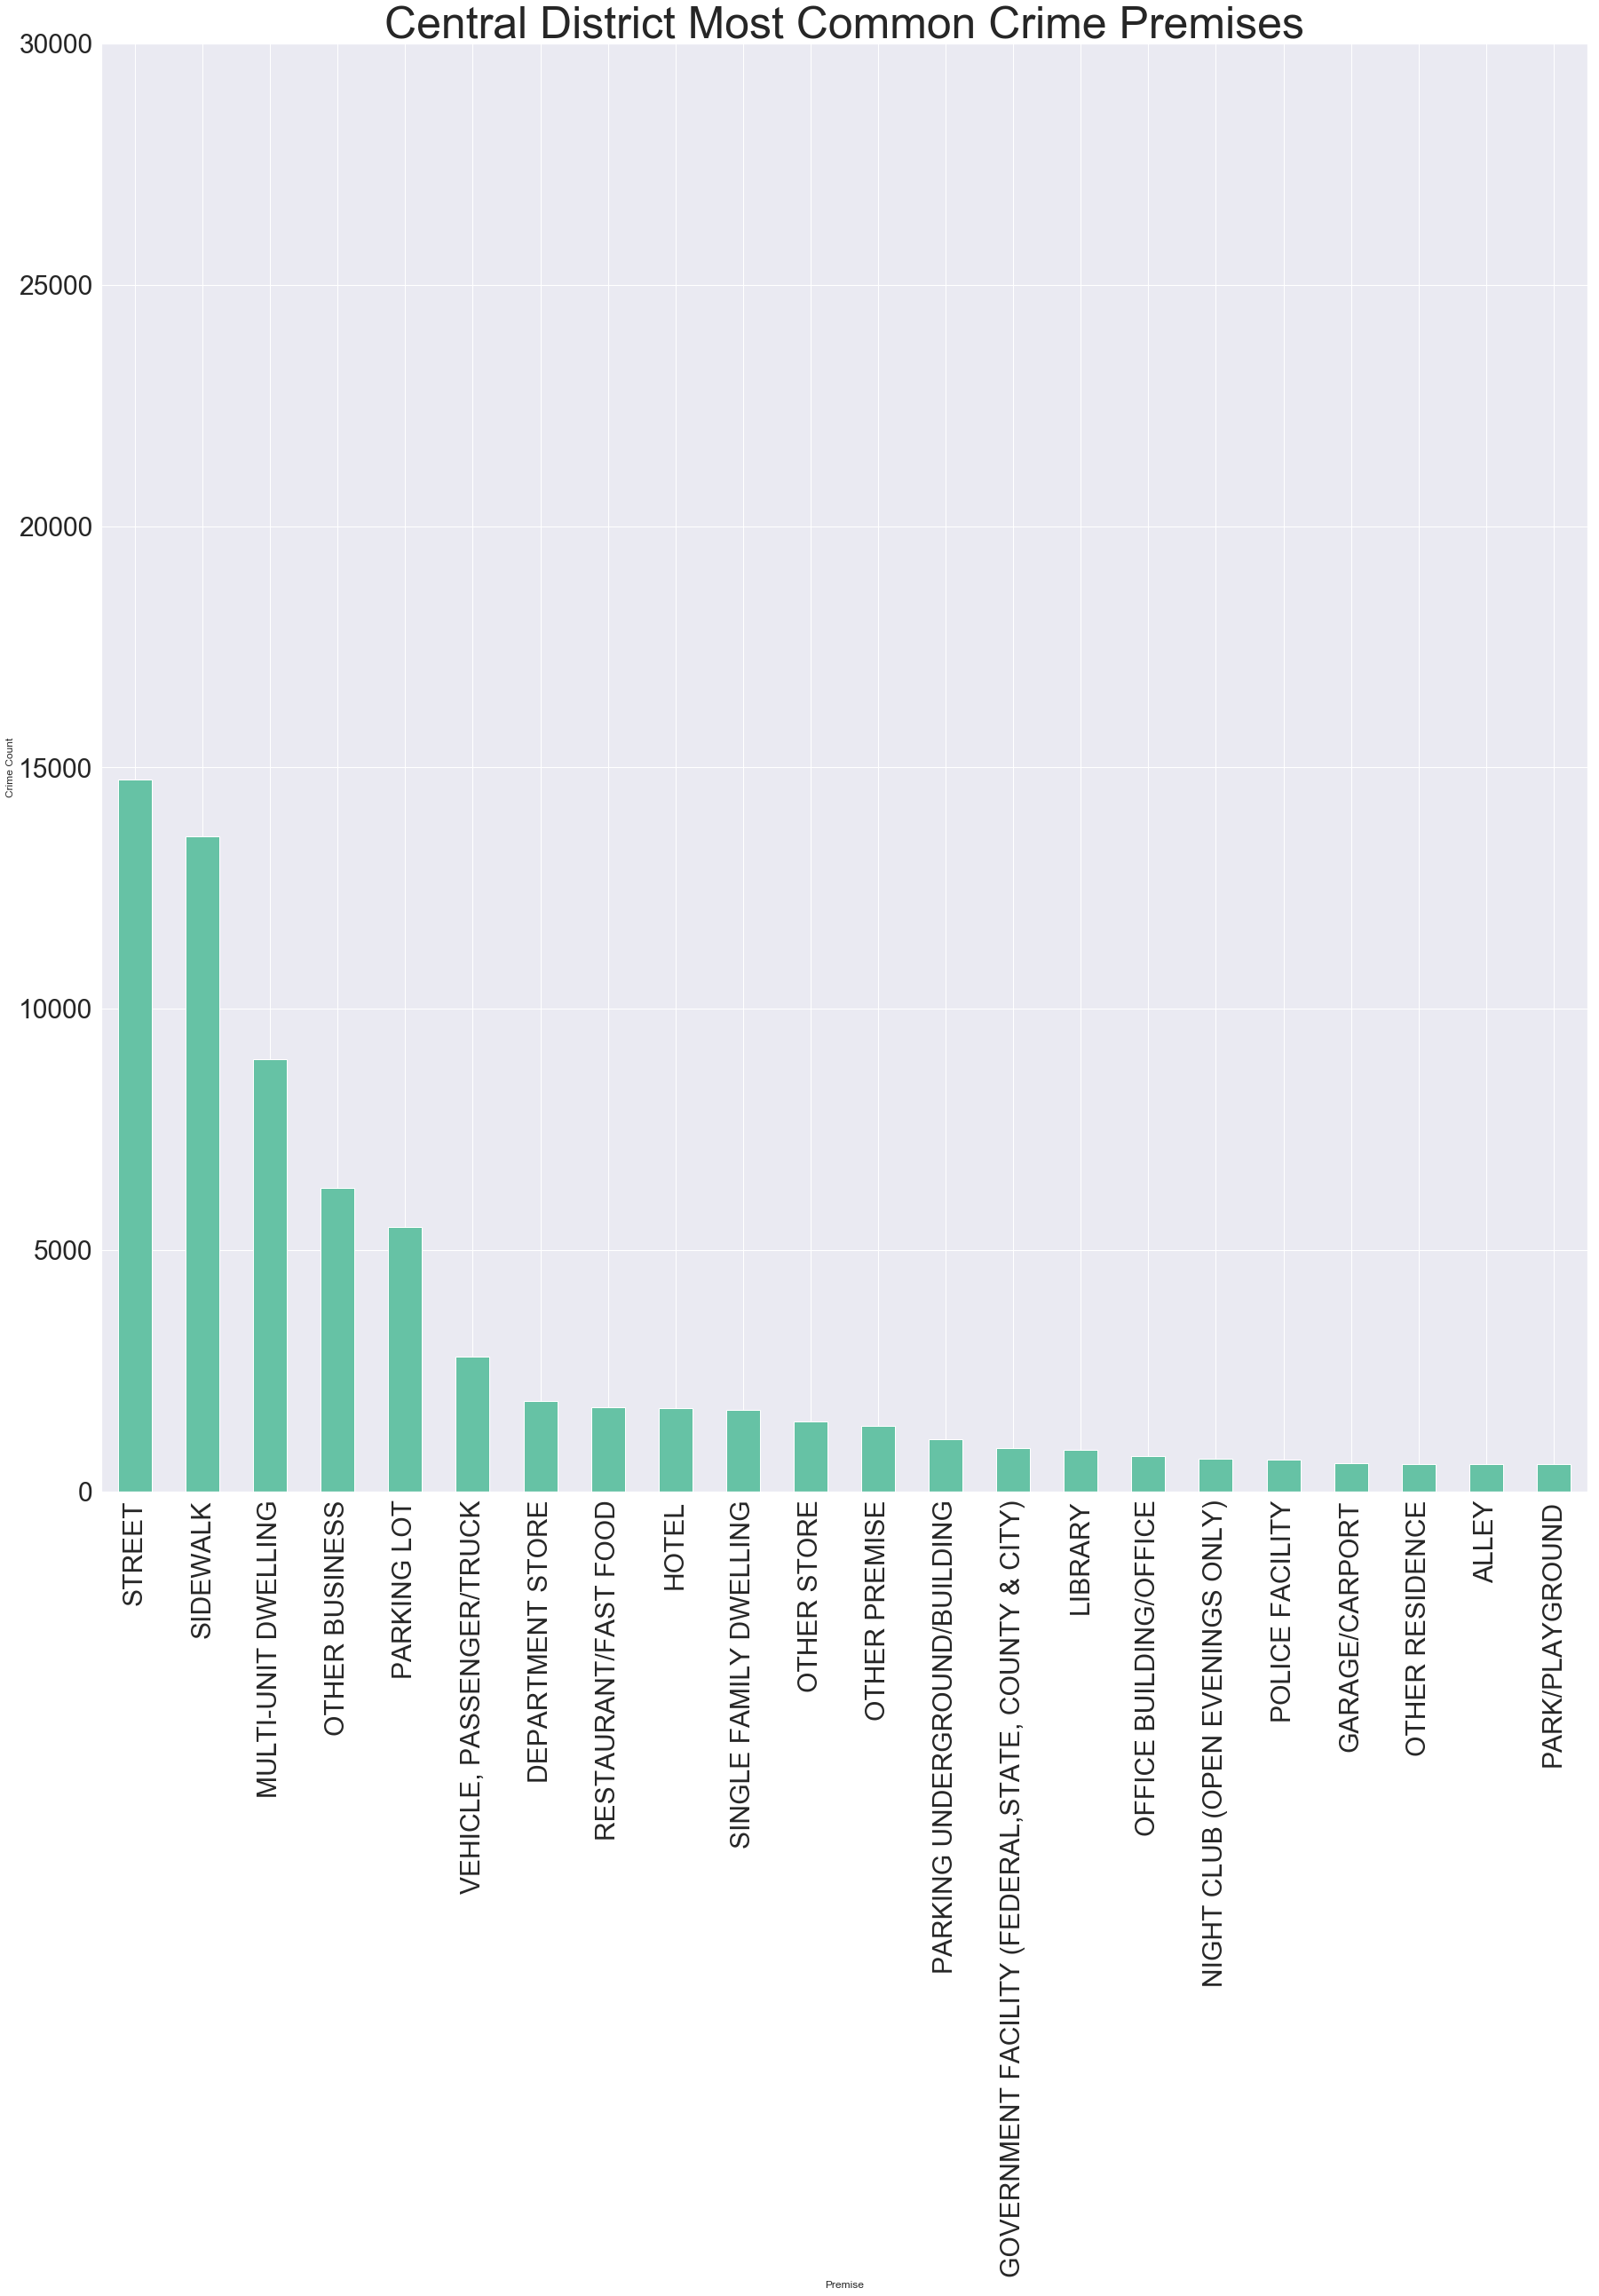

In [44]:
area_premise=df.loc[:,['Premise Description','Area Name']]
central_premise=area_premise[area_premise['Area Name']=='Central']
central_premise=central_premise.drop(columns='Area Name')
central_premise=central_premise['Premise Description'].value_counts().to_frame('Count')
central_premise=central_premise[central_premise['Count']>500]
central_premise['Count'].plot(kind='bar',figsize=(30,30),colormap='Set2')
plt.title('Central District Most Common Crime Premises',fontsize=50)
plt.xticks(fontsize=30)
plt.ylim(0,30000)
plt.yticks(fontsize=30)
plt.ylabel('Crime Count')
plt.xlabel('Premise')

In [45]:
crime_by_premise=df.loc[:,['Area Name','Crime','Premise Description']]
crime_by_premise.set_index('Area Name',inplace=True)
crime_by_premise=crime_by_premise.loc[['Central','Olympic','Newton','Hollenbeck']]
central_crime_prem=crime_by_premise.loc['Central']
central_crime_prem.reset_index(inplace=True)
central_crime_prem=central_crime_prem.groupby(['Crime','Area Name','Premise Description']).size().to_frame('Count')
central_crime_prem.reset_index(inplace=True)
central_crime_prem.drop(columns='Area Name',inplace=True)
central_crime_prem.set_index(['Premise Description','Crime'],inplace=True)
central_crime_prem=central_crime_prem.unstack(level='Crime',fill_value=0)
# defining top premises in central districts 
central_premise=['STREET','SIDEWALK','MULTI-UNIT DWELLING','PARKING LOT','OTHER BUSINESS','DEPARTMENT STORE','OTHER STORE']
central_crime_prem['Count'].loc[central_premise].plot(kind='bar',stacked=True,colormap='tab20',figsize=(100,100)) 
plt.xticks(fontsize=120)
plt.yticks(fontsize=120)
plt.legend(loc='upper right',prop={'size':120})
plt.title('Central District',fontsize=200)
plt.xlabel('Premise',fontsize=200)
plt.tight_layout()

Text(0.5,0,'Premise')

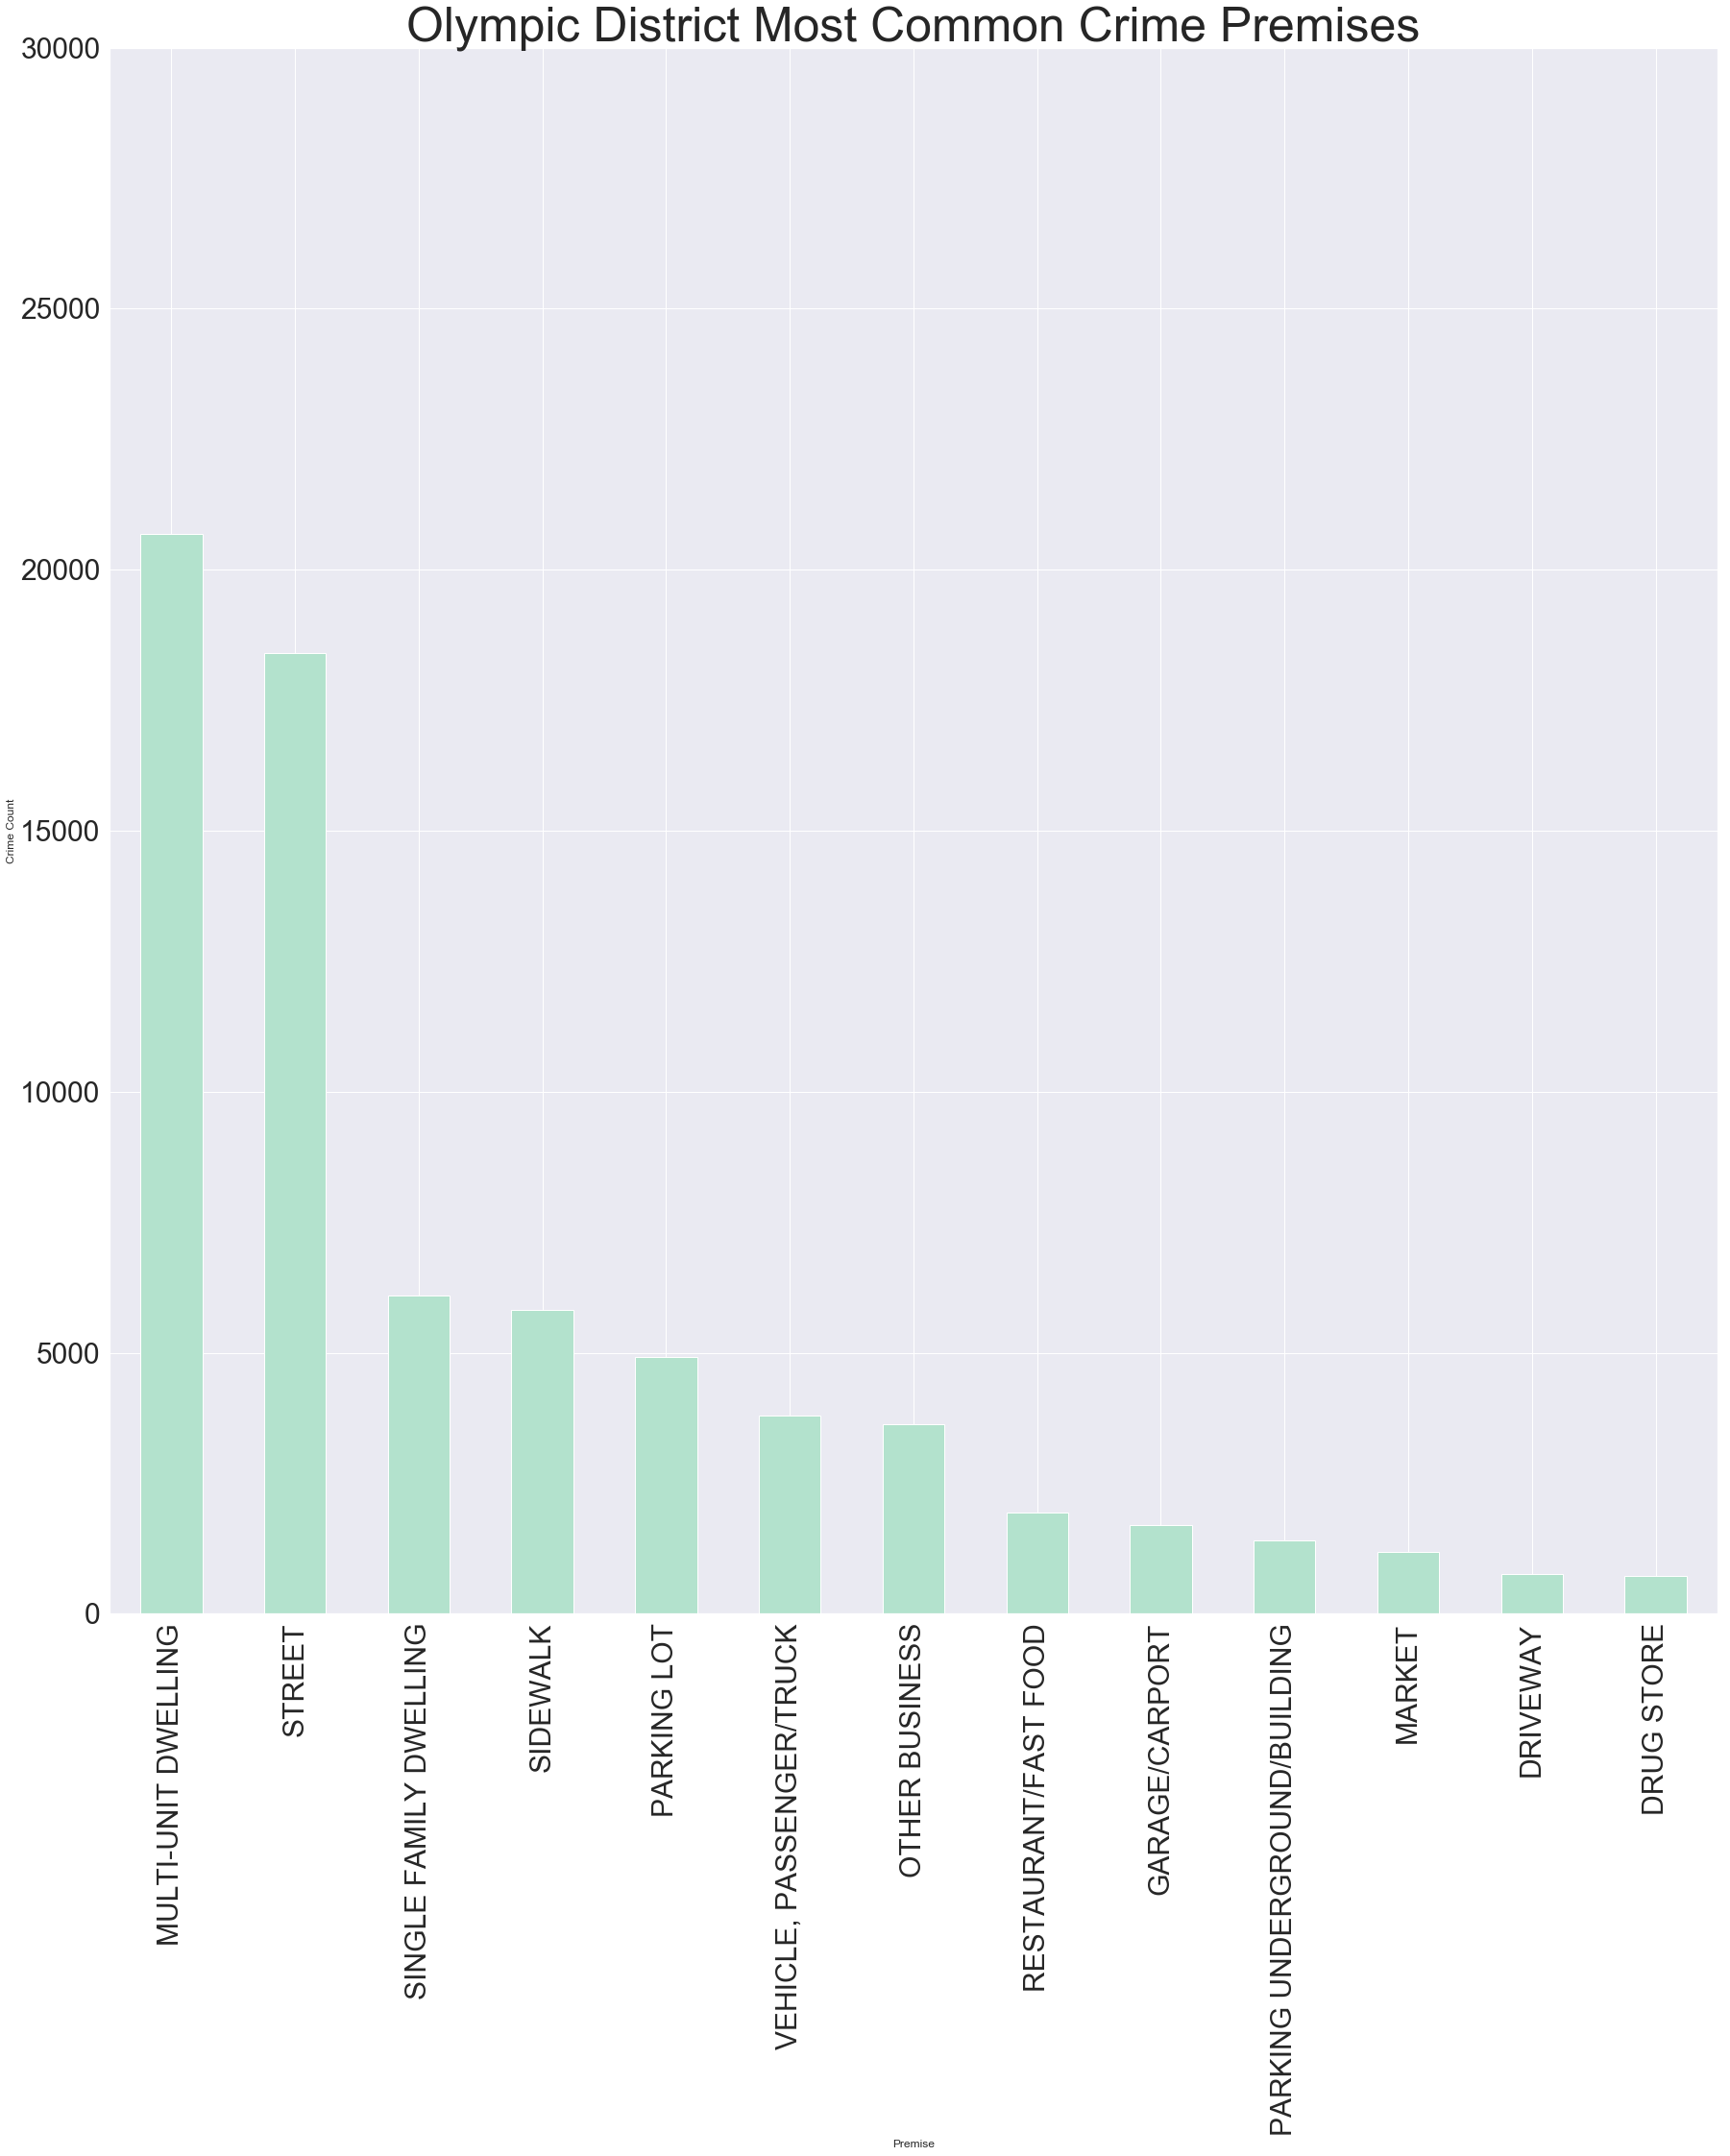

In [46]:
olympic_premise=area_premise[area_premise['Area Name']=='Olympic']
olympic_premise=olympic_premise.drop(columns='Area Name')
olympic_premise=olympic_premise['Premise Description'].value_counts().to_frame('Count')
olympic_premise=olympic_premise[olympic_premise['Count']>500]
olympic_premise['Count'].plot(kind='bar',figsize=(30,30),colormap='Pastel2')
plt.title('Olympic District Most Common Crime Premises',fontsize=50)
plt.xticks(fontsize=30)
plt.ylim(0,30000)
plt.yticks(fontsize=30)
plt.ylabel('Crime Count')
plt.xlabel('Premise')

In [47]:
olympic_crime_prem=crime_by_premise.loc['Olympic']
olympic_crime_prem.reset_index(inplace=True)
olympic_crime_prem=olympic_crime_prem.groupby(['Crime','Area Name','Premise Description']).size().to_frame('Count')
olympic_crime_prem.reset_index(inplace=True)
olympic_crime_prem.drop(columns='Area Name',inplace=True)
olympic_crime_prem.set_index(['Premise Description','Crime'],inplace=True)
olympic_crime_prem=olympic_crime_prem.unstack(level='Crime',fill_value=0)
olympic_premise=['MULTI-UNIT DWELLING','STREET','SIDEWALK','PARKING LOT','OTHER BUSINESS','DEPARTMENT STORE','OTHER STORE']
olympic_crime_prem['Count'].loc[olympic_premise].plot(kind='bar',stacked=True,colormap='tab20',figsize=(100,100)) 
plt.xticks(fontsize=120)
plt.yticks(fontsize=120)
plt.ylabel('Crime Count',fontsize=200)
plt.legend(loc='upper right',prop={'size':150})
plt.title('Olympic District',fontsize=200)
plt.xlabel('Premise',fontsize=200)
plt.tight_layout()

Text(0.5,0,'Premise')

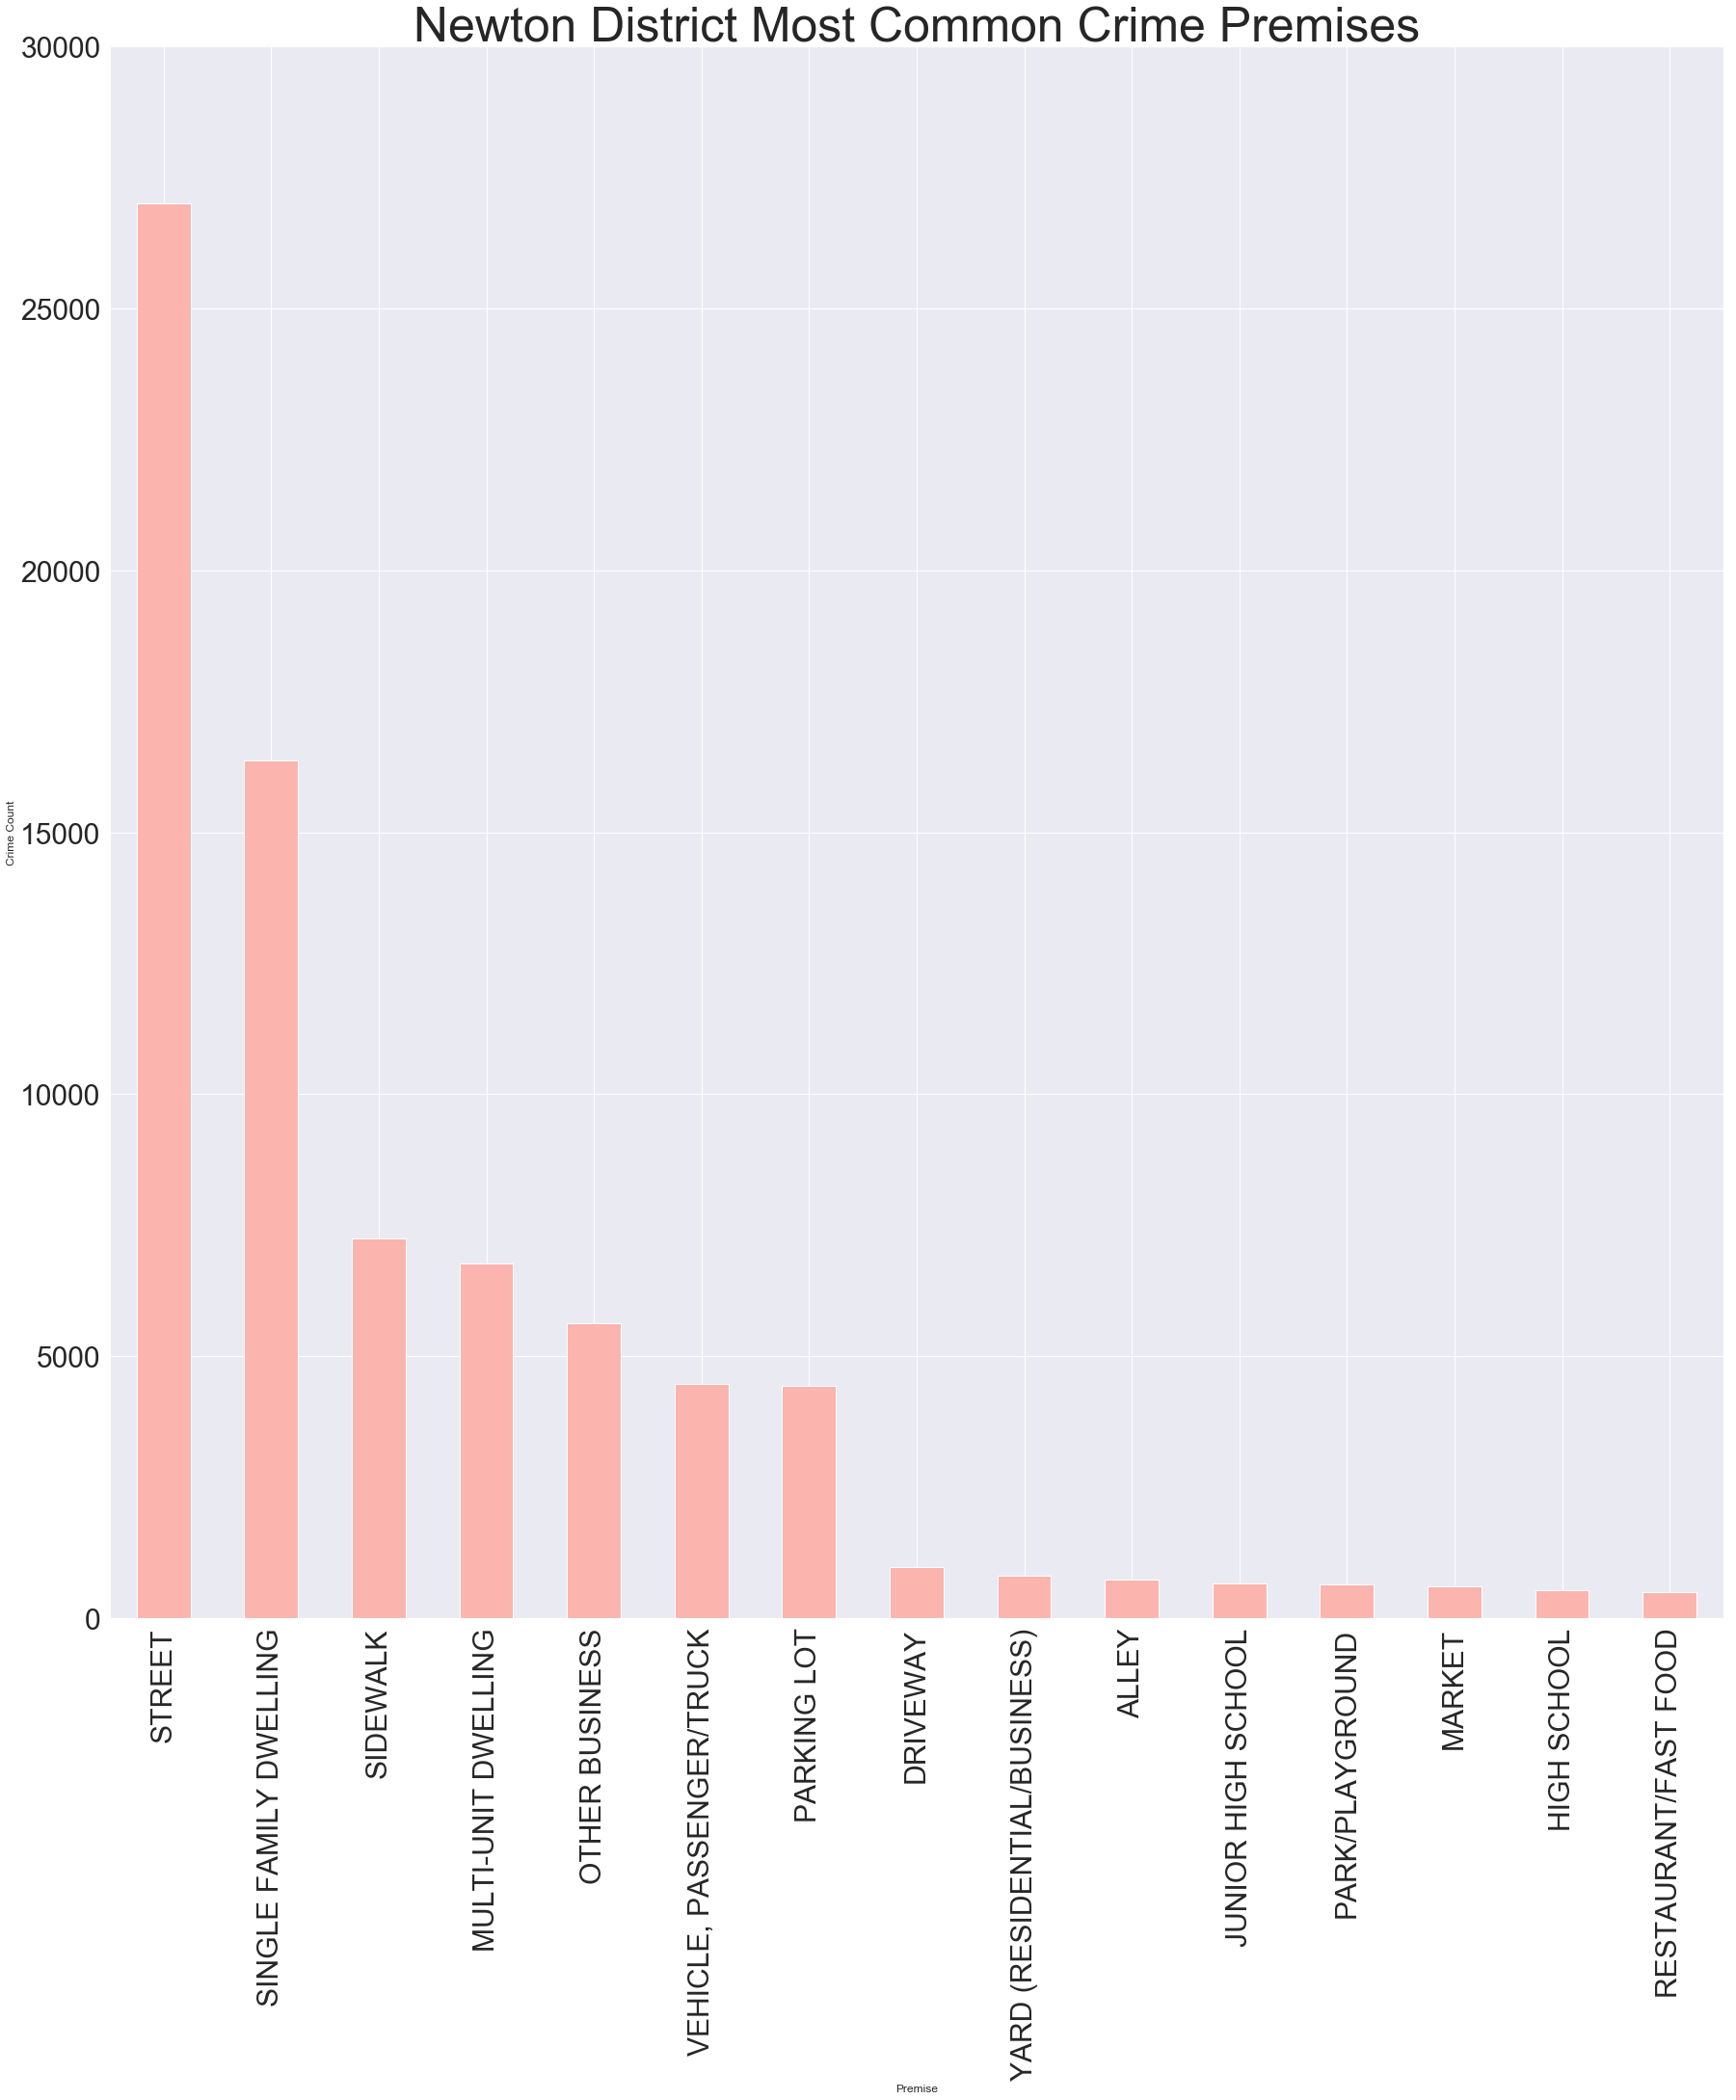

In [48]:
newton_premise=area_premise[area_premise['Area Name']=='Newton']
newton_premise=newton_premise.drop(columns='Area Name')
newton_premise=newton_premise['Premise Description'].value_counts().to_frame('Count')
newton_premise=newton_premise[newton_premise['Count']>500]
newton_premise['Count'].plot(kind='bar',figsize=(30,30),colormap='Pastel1')
plt.title('Newton District Most Common Crime Premises',fontsize=50)
plt.xticks(fontsize=30)
plt.ylim(0,30000)
plt.yticks(fontsize=30)
plt.ylabel('Crime Count')
plt.xlabel('Premise')

Text(0,0.5,'Crime Count')

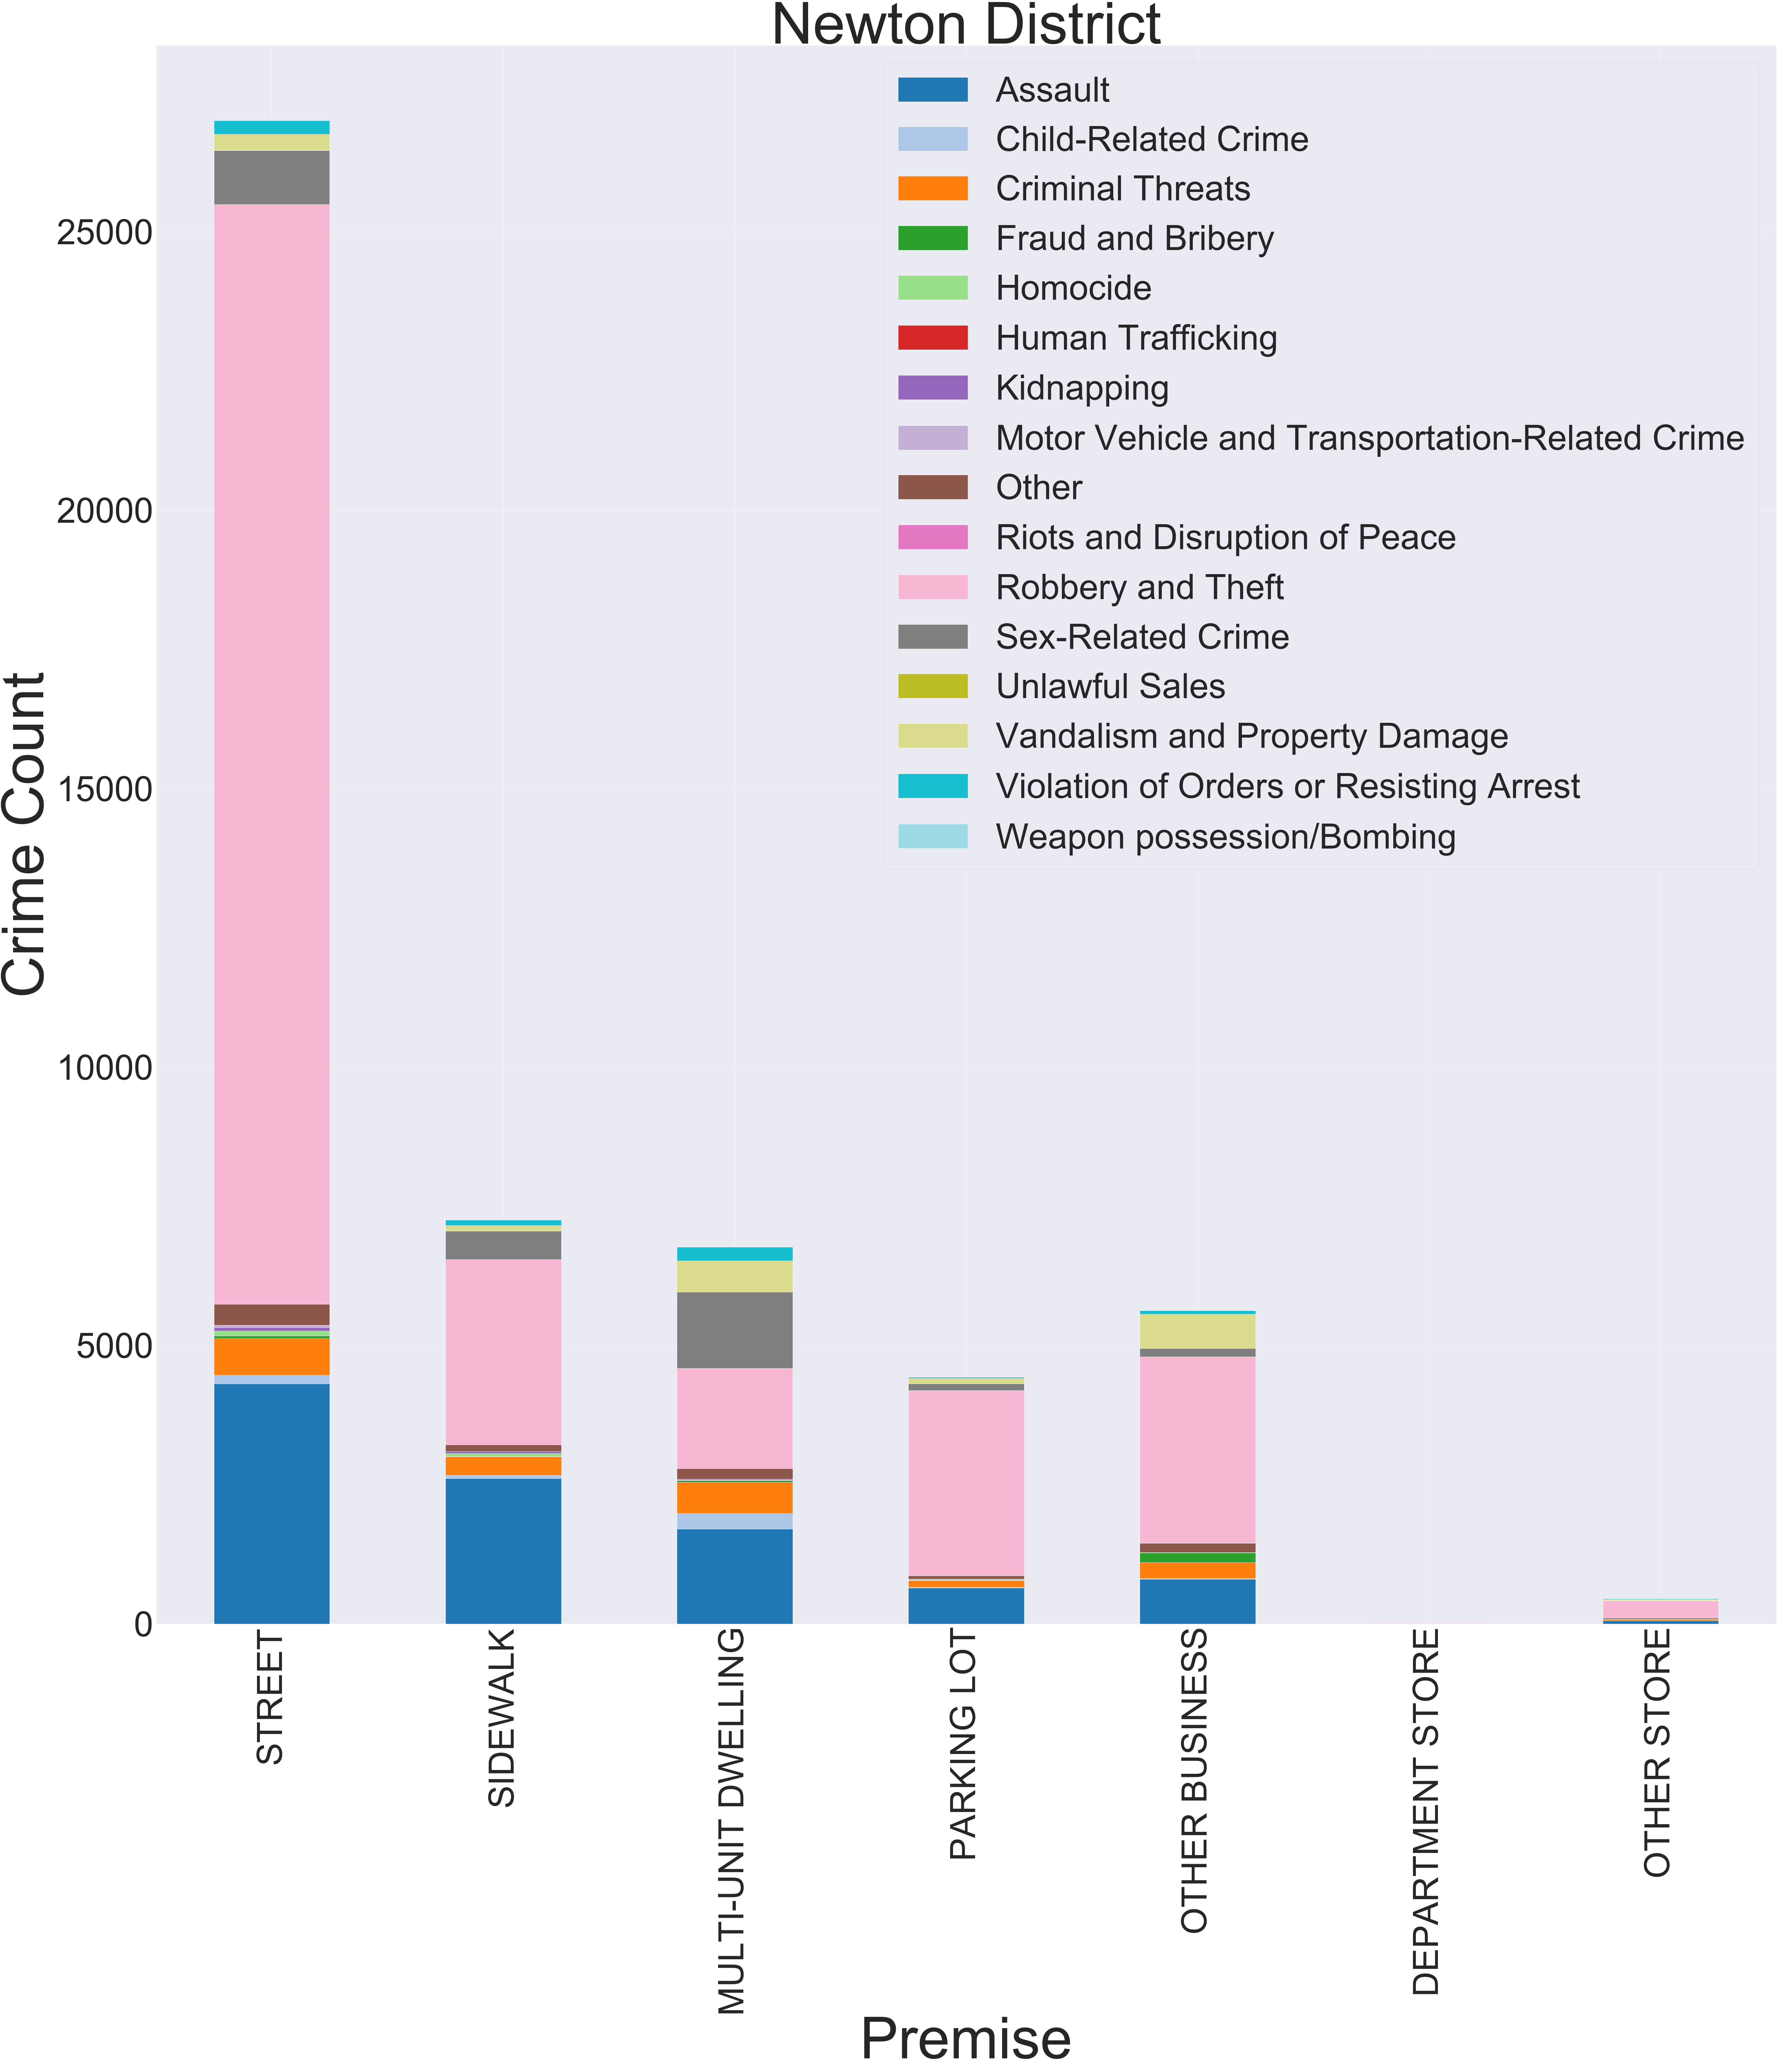

In [49]:
newton_crime_prem=crime_by_premise.loc['Newton']
newton_crime_prem.reset_index(inplace=True)
newton_crime_prem=newton_crime_prem.groupby(['Crime','Area Name','Premise Description']).size().to_frame('Count')
newton_crime_prem.reset_index(inplace=True)
newton_crime_prem.drop(columns='Area Name',inplace=True)
newton_crime_prem.set_index(['Premise Description','Crime'],inplace=True)
newton_crime_prem=newton_crime_prem.unstack(level='Crime',fill_value=0)
newton_premise=['STREET','SIDEWALK','MULTI-UNIT DWELLING','PARKING LOT','OTHER BUSINESS','DEPARTMENT STORE','OTHER STORE']
newton_crime_prem['Count'].loc[newton_premise].plot(kind='bar',stacked=True,colormap='tab20',figsize=(100,100)) 
plt.xticks(fontsize=120)
plt.yticks(fontsize=120)
plt.legend(loc='upper right',prop={'size':120})
plt.title('Newton District',fontsize=200)
plt.xlabel('Premise',fontsize=200)
plt.ylabel('Crime Count',fontsize=200)

Text(0.5,0,'Premise')

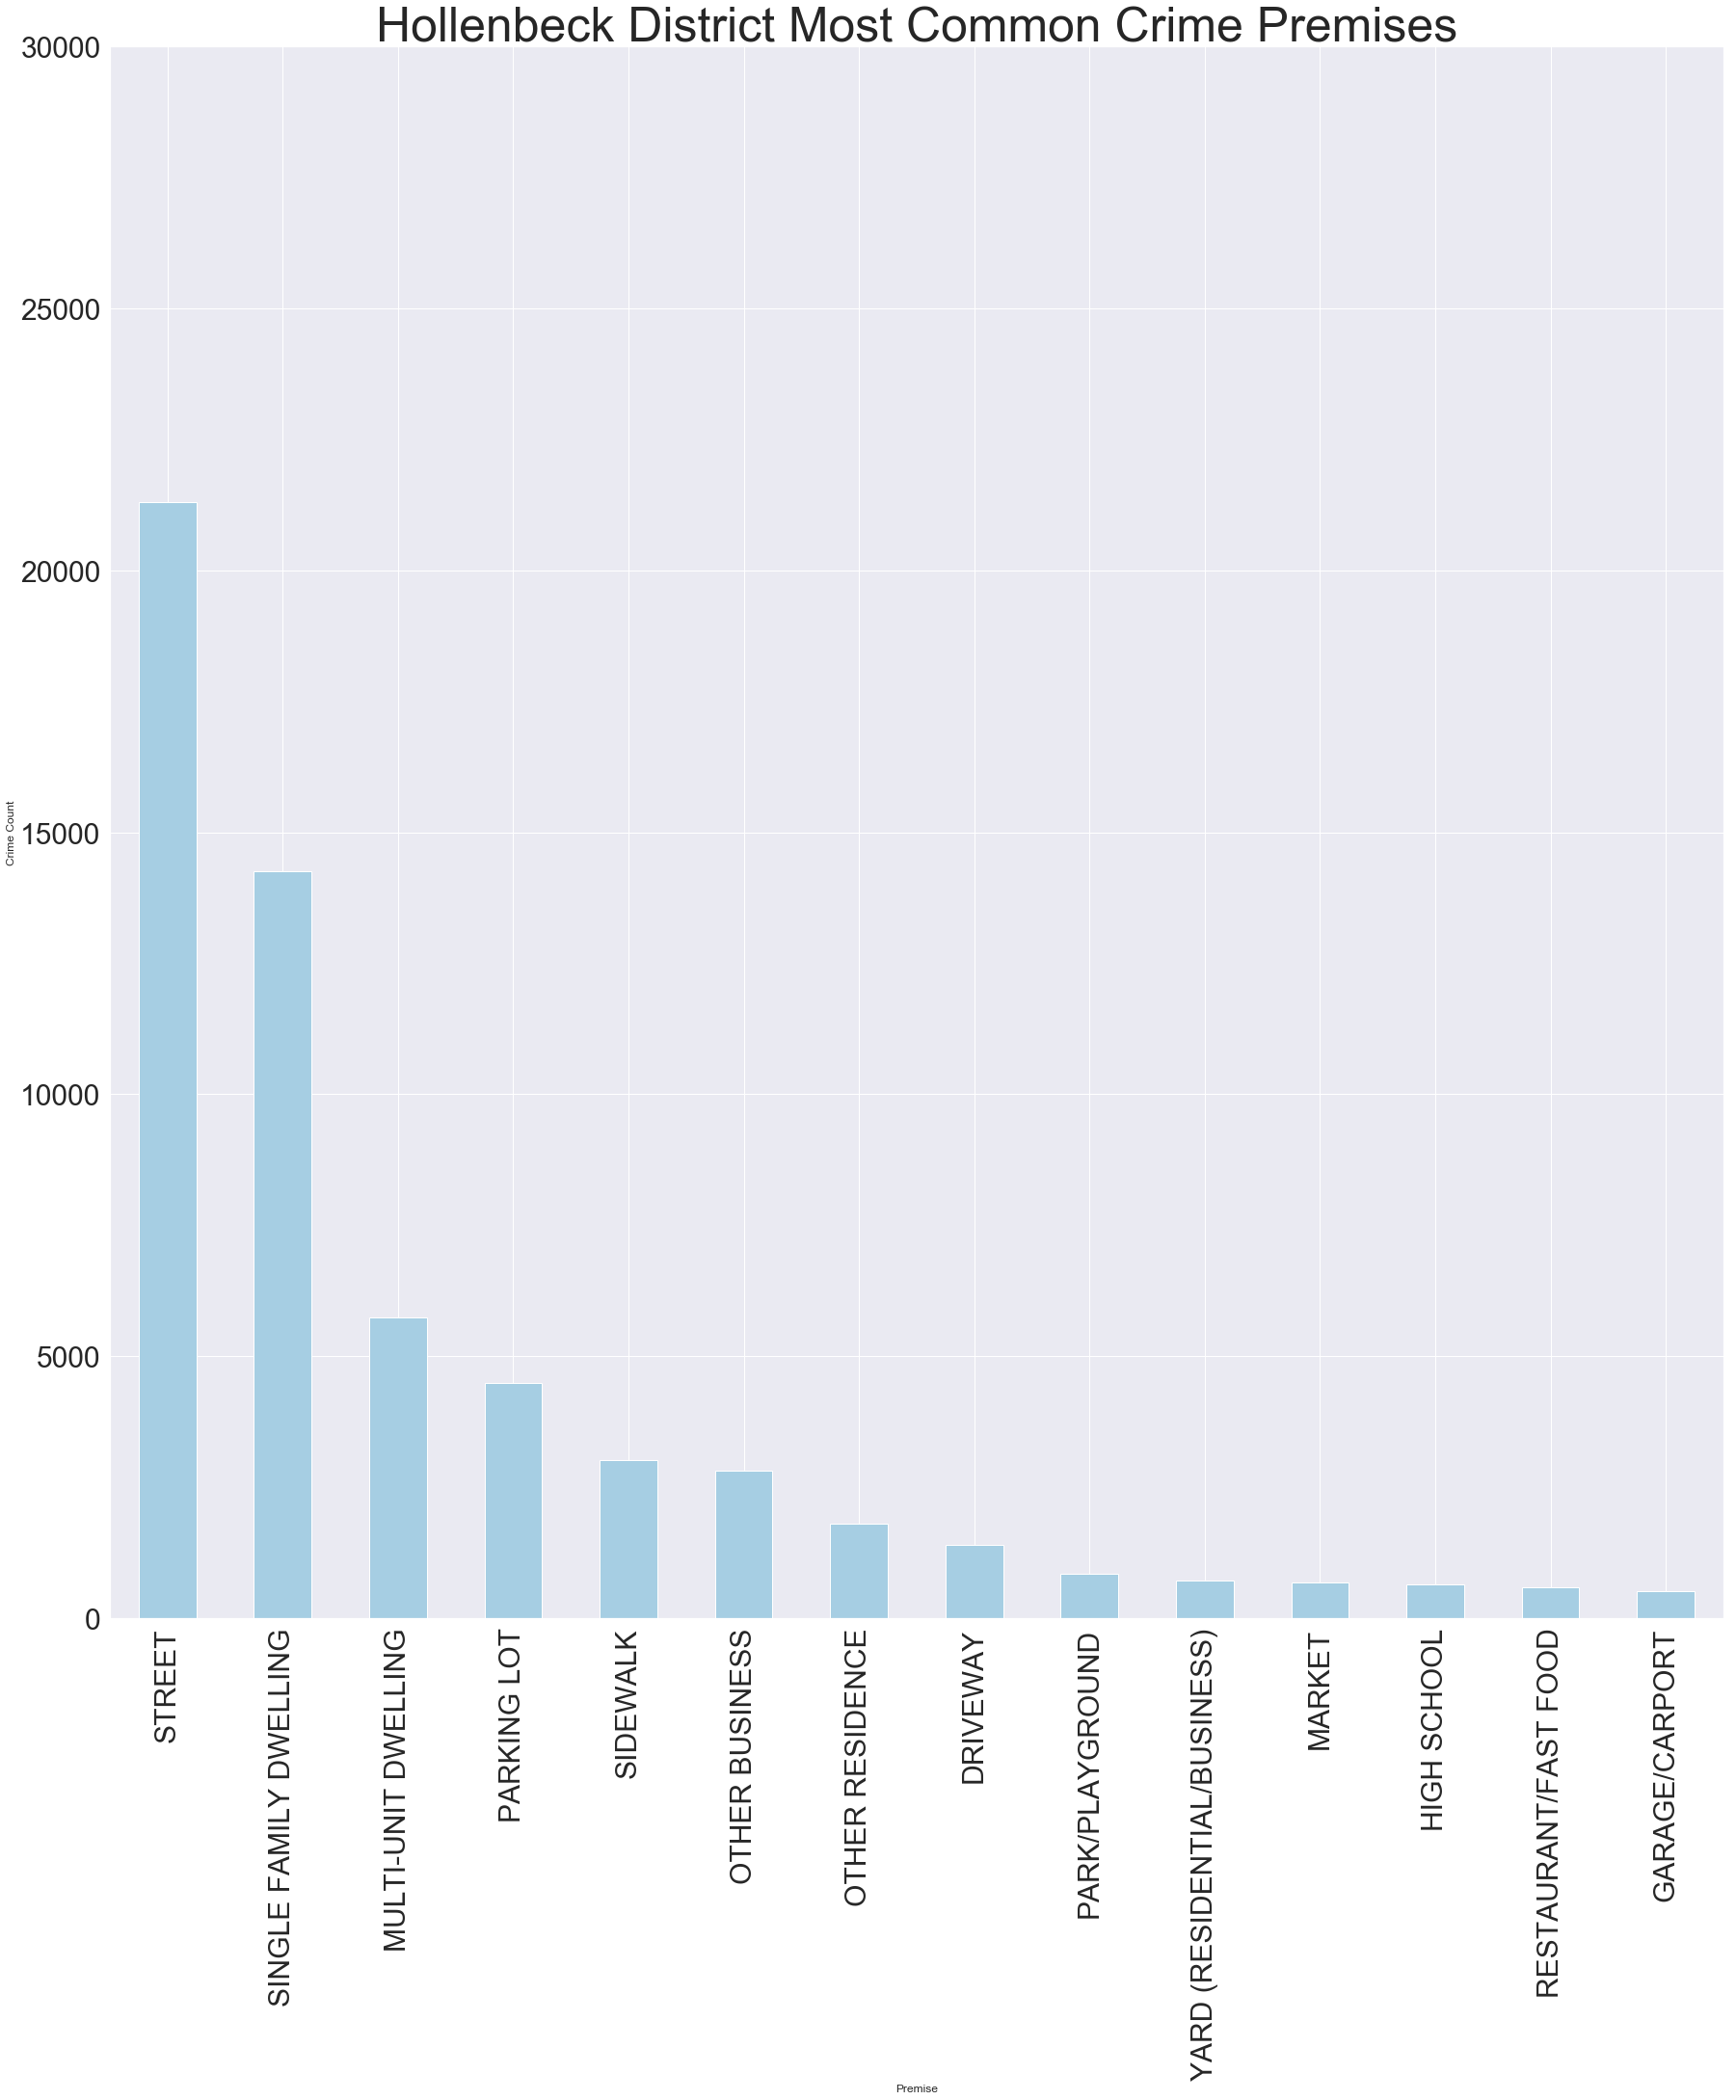

In [50]:
hollenbeck_premise=area_premise[area_premise['Area Name']=='Hollenbeck']
hollenbeck_premise=hollenbeck_premise.drop(columns='Area Name')
hollenbeck_premise=hollenbeck_premise['Premise Description'].value_counts().to_frame('Count')
hollenbeck_premise=hollenbeck_premise[hollenbeck_premise['Count']>500]
hollenbeck_premise['Count'].plot(kind='bar',figsize=(30,30),colormap='Paired')
plt.title('Hollenbeck District Most Common Crime Premises',fontsize=50)
plt.xticks(fontsize=30)
plt.ylim(0,30000)
plt.yticks(fontsize=30)
plt.ylabel('Crime Count')
plt.xlabel('Premise')

Text(0,0.5,'Crime Count')

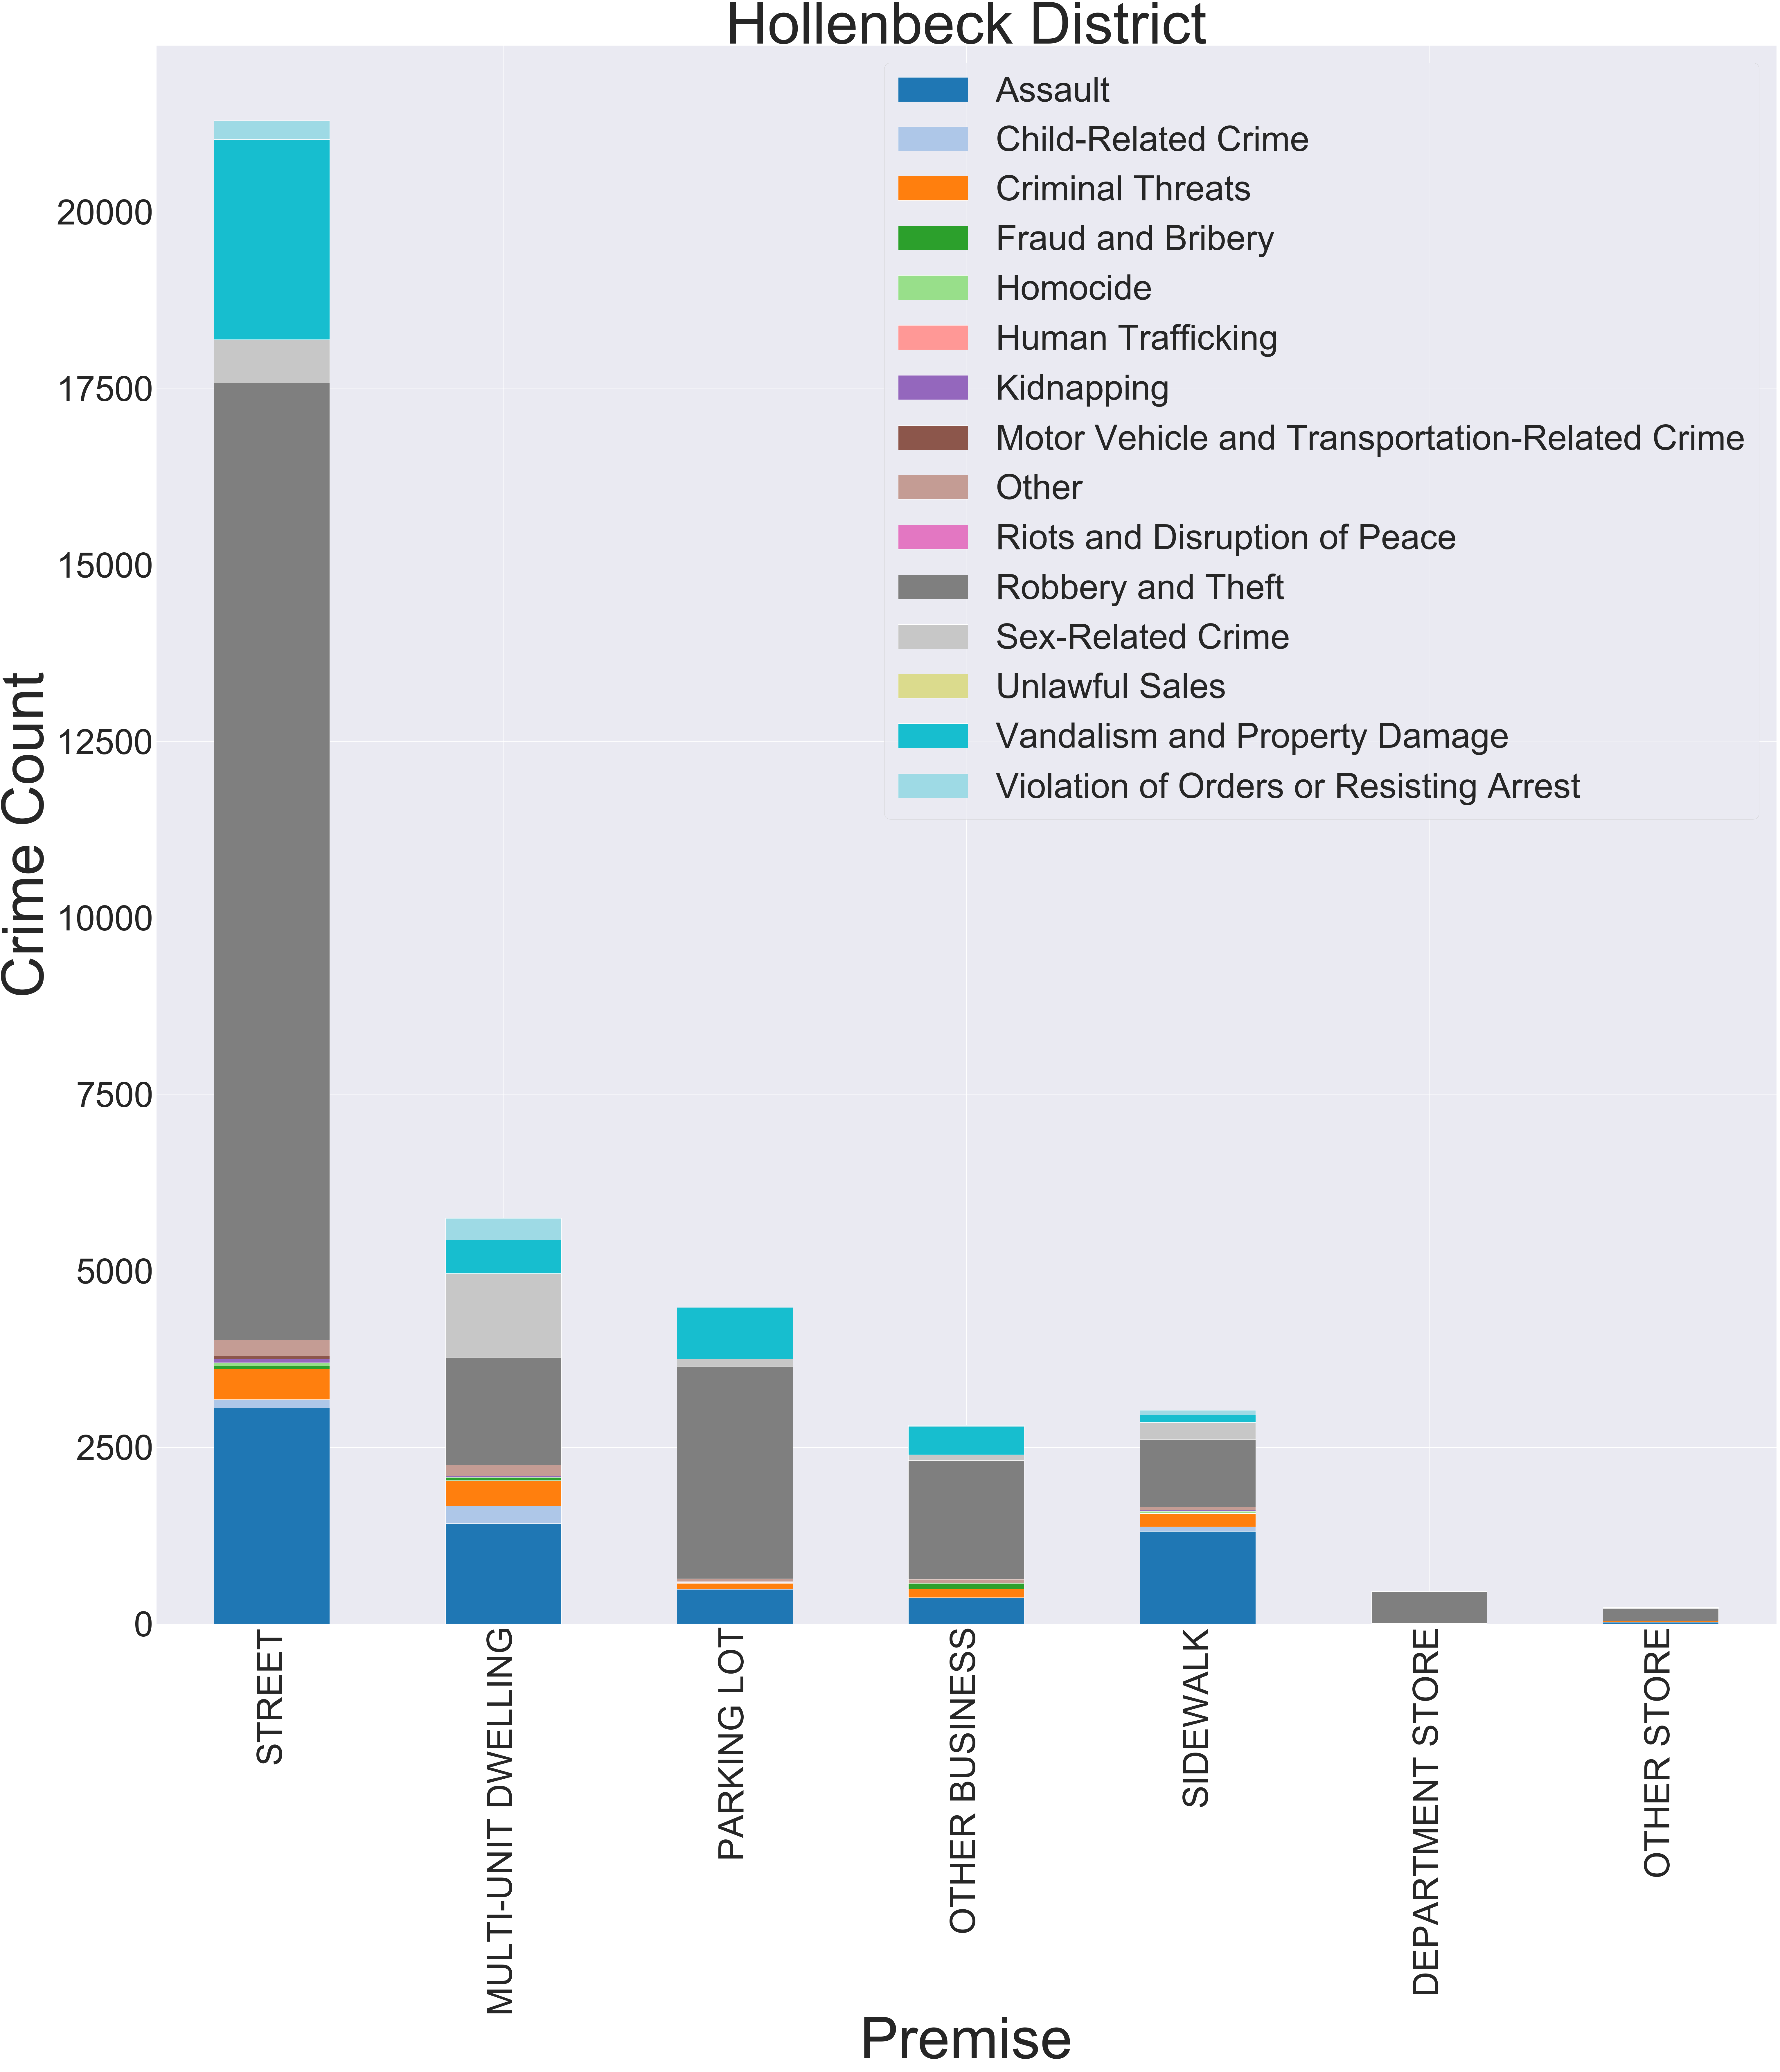

In [51]:
hollen_crime_prem=crime_by_premise.loc['Hollenbeck']
hollen_crime_prem.reset_index(inplace=True)
hollen_crime_prem=hollen_crime_prem.groupby(['Crime','Area Name','Premise Description']).size().to_frame('Count')
hollen_crime_prem.reset_index(inplace=True)
hollen_crime_prem.drop(columns='Area Name',inplace=True)
hollen_crime_prem.set_index(['Premise Description','Crime'],inplace=True)
hollen_crime_prem=hollen_crime_prem.unstack(level='Crime',fill_value=0)
hollen_premise=['STREET','MULTI-UNIT DWELLING','PARKING LOT','OTHER BUSINESS','SIDEWALK','DEPARTMENT STORE','OTHER STORE']
hollen_crime_prem['Count'].loc[hollen_premise].plot(kind='bar',stacked=True,colormap='tab20',figsize=(100,100)) 
plt.xticks(fontsize=120)
plt.yticks(fontsize=120)
plt.legend(loc='upper right',prop={'size':120})
plt.title('Hollenbeck District',fontsize=200)
plt.xlabel('Premise',fontsize=200)
plt.ylabel('Crime Count',fontsize=200)

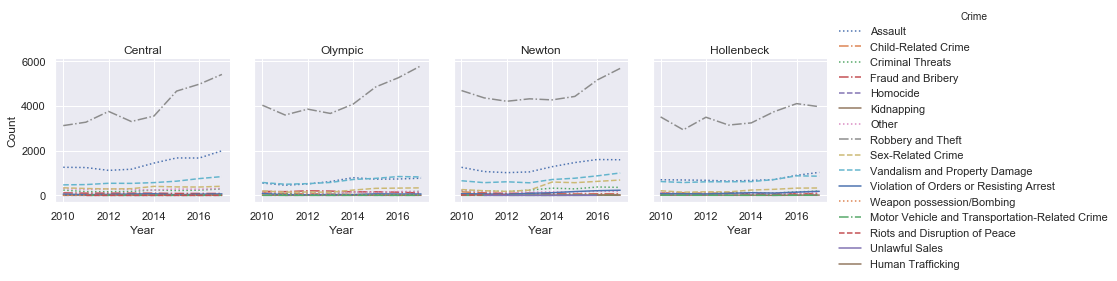

In [52]:
inv_cont=df.loc[:,['Date Occurred_Time Occurred','Crime','Status Description','Area Name']]
inv_cont=inv_cont[inv_cont['Status Description']=='Invest Cont']
inv_cont=inv_cont.set_index('Area Name')
inv_cont=inv_cont.loc[['Central','Olympic','Newton','Hollenbeck']]
inv_cont['Year']=inv_cont['Date Occurred_Time Occurred'].dt.year
inv_cont=inv_cont[inv_cont['Year']!=2018]
inv_cont.drop(columns=['Date Occurred_Time Occurred','Status Description'],inplace=True)
inv_cont=inv_cont.groupby(['Year','Area Name','Crime']).size().to_frame('Count')
inv_cont.reset_index(inplace=True)
g=sns.FacetGrid(inv_cont,col='Area Name',hue='Crime',palette='deep',hue_kws={'ls':[':','-.',':','-.','--','-',':','-.','--','--','-',':','-.','--','-','-',':']},col_order=['Central','Olympic','Newton','Hollenbeck'])
g.map(plt.plot,'Year','Count')
g.add_legend()
g.set_titles("{col_name}")

In [53]:
df.head()

Date Occurred_Time Occurred    Area Name  \
0         2013-03-11 18:00:00  77th Street   
1         2010-01-22 23:00:00      Olympic   
2         2013-03-18 20:30:00    Southeast   
3         2010-11-10 18:00:00    Southeast   
4         2014-01-04 23:00:00      Topanga   

                     Crime Code Description Victim Age Victim Sex  \
0         INTIMATE PARTNER - SIMPLE ASSAULT         30          F   
1                          VEHICLE - STOLEN    Missing    Missing   
2                          VEHICLE - STOLEN         12    Missing   
3                          VEHICLE - STOLEN    Missing    Missing   
4  VANDALISM - MISDEAMEANOR ($399 OR UNDER)         84          M   

  Victim Descent     Premise Description Status Description  \
0              W     MULTI-UNIT DWELLING        Adult Other   
1        Missing                  STREET        Invest Cont   
2        Missing                  STREET        Invest Cont   
3        Missing                  STREET        Invest Cont   
4              W  SINGLE FAMILY DWELLING        Invest Cont   

              Location  Date Occurred               ...                 \
0  (33.9829, -118.3338)    2013-03-11               ...                  
1  (34.0454, -118.3157)    2010-01-22               ...                  
2   (33.942, -118.2717)    2013-03-18               ...                  
3  (33.9572, -118.2717)    2010-11-10               ...                  
4  (34.2009, -118.6369)    2014-01-04               ...                  

       Hour_cos       Min_sin  Min_cos   Day_sin   Day_cos     Month_sin  \
0 -1.836970e-16  0.000000e+00      1.0  0.790776 -0.612106 -5.000000e-01   
1  9.659258e-01  0.000000e+00      1.0 -0.968077 -0.250653 -8.660254e-01   
2  5.000000e-01 -1.715001e-14      1.0 -0.485302 -0.874347  3.673940e-16   
3 -1.836970e-16  0.000000e+00      1.0  0.897805 -0.440394 -8.660254e-01   
4  9.659258e-01  0.000000e+00      1.0  0.724793  0.688967  8.660254e-01   

   Month_cos  Time Code                          Crime  \
0   0.866025    Evening              Sex-Related Crime   
1   0.500000      Night              Robbery and Theft   
2  -1.000000    Evening              Robbery and Theft   
3   0.500000    Evening              Robbery and Theft   
4  -0.500000      Night  Vandalism and Property Damage   

                    Crime_Detailed  
0  Rape and Sexual Assault/Battery  
1     Vehicle/Transportation Theft  
2     Vehicle/Transportation Theft  
3     Vehicle/Transportation Theft  
4    Vandalism and Property Damage  

[5 rows x 26 columns]

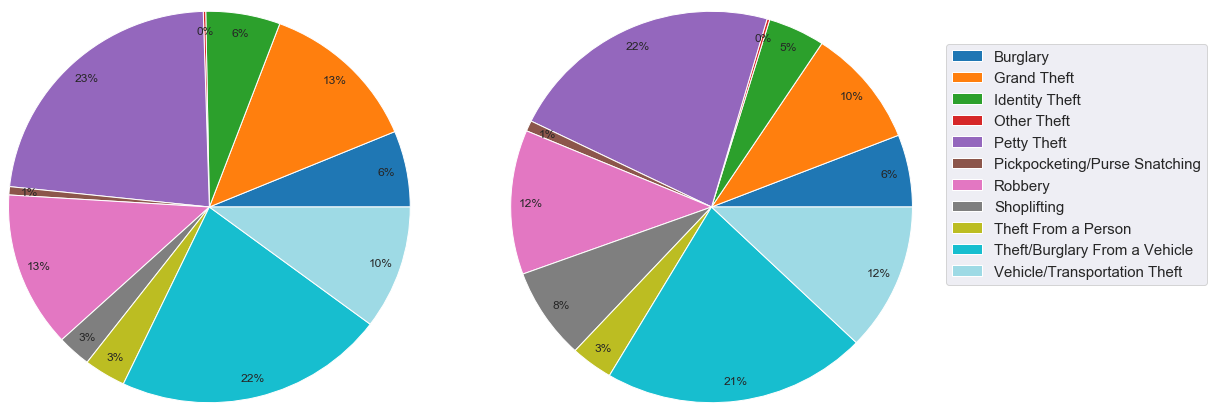

In [54]:
dcrime_by_district=df.loc[:,['Area Name','Crime','Crime_Detailed','Date Occurred_Time Occurred']]
dcrime_by_district['Date Occurred']=dcrime_by_district['Date Occurred_Time Occurred'].dt.year
dcrime_central=dcrime_by_district[(dcrime_by_district['Area Name']=='Central') & (dcrime_by_district['Crime']=='Robbery and Theft')]
dcrime_central_before=dcrime_central[dcrime_central['Date Occurred']<2013]
dcrime_central_after=dcrime_central[dcrime_central['Date Occurred']>=2013]
dcrime_central_before=dcrime_central_before.groupby(['Crime_Detailed']).size().to_frame('Count')
dcrime_central_after=dcrime_central_after.groupby(['Crime_Detailed']).size().to_frame('Count')
figs,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
dcrime_central_after.plot.pie(ax=axes[1],y='Count',colormap='tab20',labels=None,autopct='%1.0f%%',pctdistance=.90, radius=1.5)
dcrime_central_before.plot.pie(ax=axes[0],y='Count',colormap='tab20',labels=None,autopct='%1.0f%%',pctdistance=.90, radius=1.5,legend=False)
figs.subplots_adjust(wspace=.5)
axes[1].legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.,prop={'size':15},labels=dcrime_central_after.index)

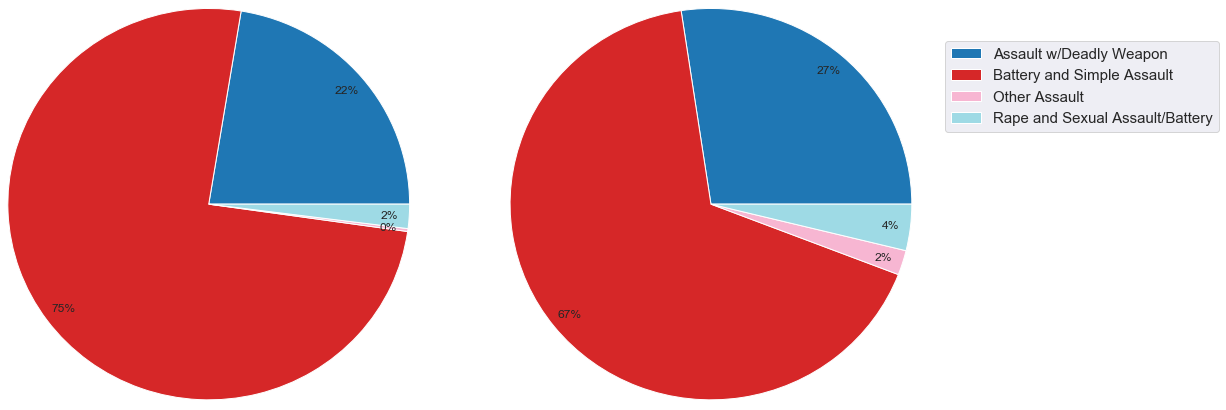

In [55]:
dcrime_by_district=df.loc[:,['Area Name','Crime','Crime_Detailed','Date Occurred_Time Occurred']]
dcrime_by_district['Date Occurred']=dcrime_by_district['Date Occurred_Time Occurred'].dt.year
dcrime_central=dcrime_by_district[(dcrime_by_district['Area Name']=='Central') & (dcrime_by_district['Crime']=='Assault')]
dcrime_central_before=dcrime_central[dcrime_central['Date Occurred']<2013]
dcrime_central_after=dcrime_central[dcrime_central['Date Occurred']>=2013]
dcrime_central_before=dcrime_central_before.groupby(['Crime_Detailed']).size().to_frame('Count')
dcrime_central_after=dcrime_central_after.groupby(['Crime_Detailed']).size().to_frame('Count')
figs,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
dcrime_central_after.plot.pie(ax=axes[1],y='Count',colormap='tab20',labels=None,autopct='%1.0f%%',pctdistance=.90, radius=1.5)
dcrime_central_before.plot.pie(ax=axes[0],y='Count',colormap='tab20',labels=None,autopct='%1.0f%%',pctdistance=.90, radius=1.5,legend=False)
figs.subplots_adjust(wspace=.5)
axes[1].legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.,prop={'size':15},labels=dcrime_central_after.index)

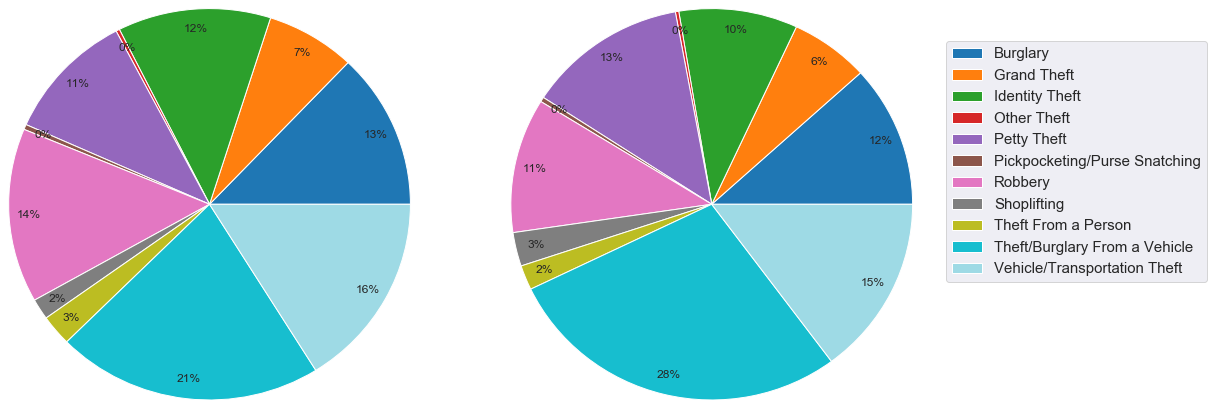

In [56]:
dcrime_olympic=dcrime_by_district[(dcrime_by_district['Area Name']=='Olympic') & (dcrime_by_district['Crime']=='Robbery and Theft')]
dcrime_olympic_before=dcrime_olympic[dcrime_olympic['Date Occurred']<2013]
dcrime_olympic_after=dcrime_olympic[dcrime_olympic['Date Occurred']>=2013]
dcrime_olympic_before=dcrime_olympic_before.groupby(['Crime_Detailed']).size().to_frame('Count')
dcrime_olympic_after=dcrime_olympic_after.groupby(['Crime_Detailed']).size().to_frame('Count')
figs,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
dcrime_olympic_after.plot.pie(ax=axes[1],y='Count',colormap='tab20',labels=None,autopct='%1.0f%%',pctdistance=.90, radius=1.5)
dcrime_olympic_before.plot.pie(ax=axes[0],y='Count',colormap='tab20',labels=None,autopct='%1.0f%%',pctdistance=.90, radius=1.5,legend=False)
figs.subplots_adjust(wspace=.5)
axes[1].legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.,prop={'size':15},labels=dcrime_olympic_after.index)

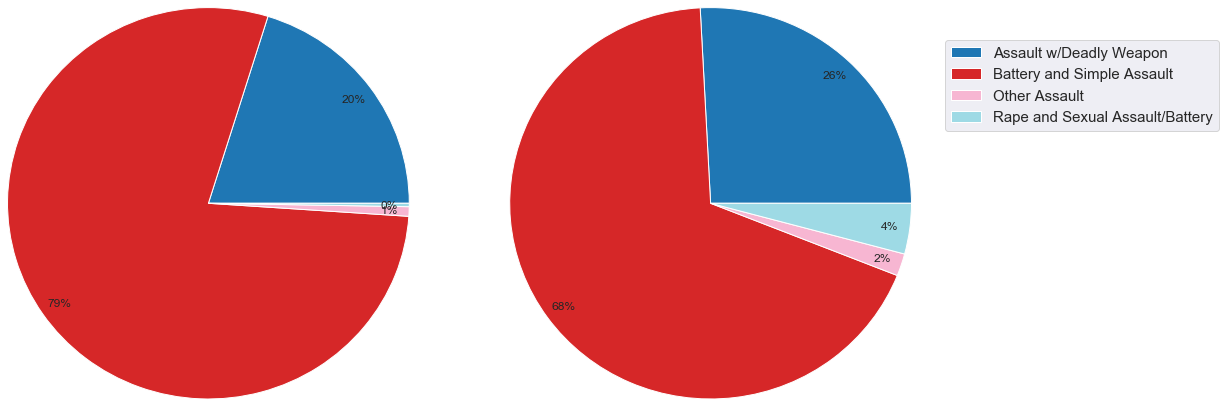

In [57]:
dcrime_olympic=dcrime_by_district[(dcrime_by_district['Area Name']=='Olympic') & (dcrime_by_district['Crime']=='Assault')]
dcrime_olympic_before=dcrime_olympic[dcrime_olympic['Date Occurred']<2013]
dcrime_olympic_after=dcrime_olympic[dcrime_olympic['Date Occurred']>=2013]
dcrime_olympic_before=dcrime_olympic_before.groupby(['Crime_Detailed']).size().to_frame('Count')
dcrime_olympic_after=dcrime_olympic_after.groupby(['Crime_Detailed']).size().to_frame('Count')
figs,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
dcrime_olympic_after.plot.pie(ax=axes[1],y='Count',colormap='tab20',labels=None,autopct='%1.0f%%',pctdistance=.90, radius=1.5)
dcrime_olympic_before.plot.pie(ax=axes[0],y='Count',colormap='tab20',labels=None,autopct='%1.0f%%',pctdistance=.90, radius=1.5,legend=False)
figs.subplots_adjust(wspace=.5)
axes[1].legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.,prop={'size':15},labels=dcrime_olympic_after.index)

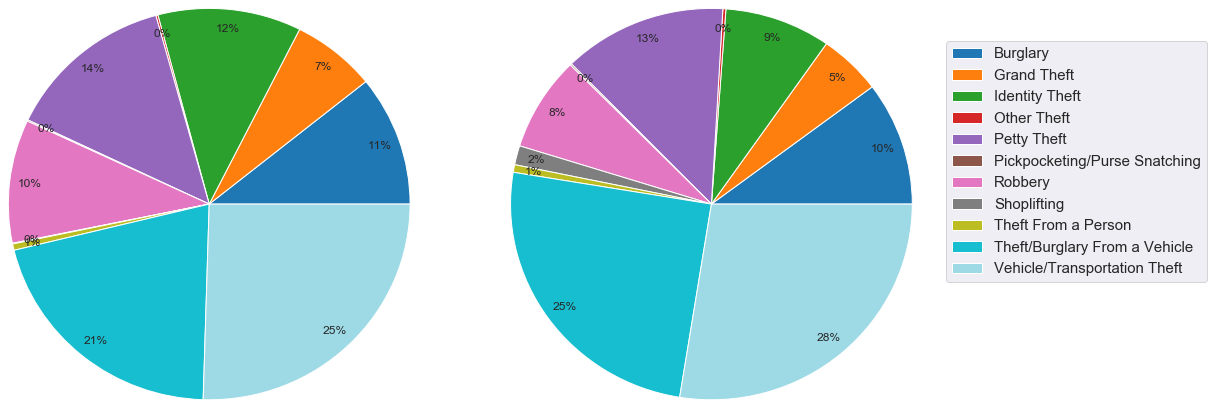

In [58]:
dcrime_hollenbeck=dcrime_by_district[(dcrime_by_district['Area Name']=='Hollenbeck') & (dcrime_by_district['Crime']=='Robbery and Theft')]
dcrime_hollenbeck_before=dcrime_hollenbeck[dcrime_hollenbeck['Date Occurred']<2013]
dcrime_hollenbeck_after=dcrime_hollenbeck[dcrime_hollenbeck['Date Occurred']>=2013]
dcrime_hollenbeck_before=dcrime_hollenbeck_before.groupby(['Crime_Detailed']).size().to_frame('Count')
dcrime_hollenbeck_after=dcrime_hollenbeck_after.groupby(['Crime_Detailed']).size().to_frame('Count')
figs,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
dcrime_hollenbeck_after.plot.pie(ax=axes[1],y='Count',colormap='tab20',labels=None,autopct='%1.0f%%',pctdistance=.90, radius=1.5)
dcrime_hollenbeck_before.plot.pie(ax=axes[0],y='Count',colormap='tab20',labels=None,autopct='%1.0f%%',pctdistance=.90, radius=1.5,legend=False)
figs.subplots_adjust(wspace=.5)
axes[1].legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.,prop={'size':15},labels=dcrime_hollenbeck_after.index)

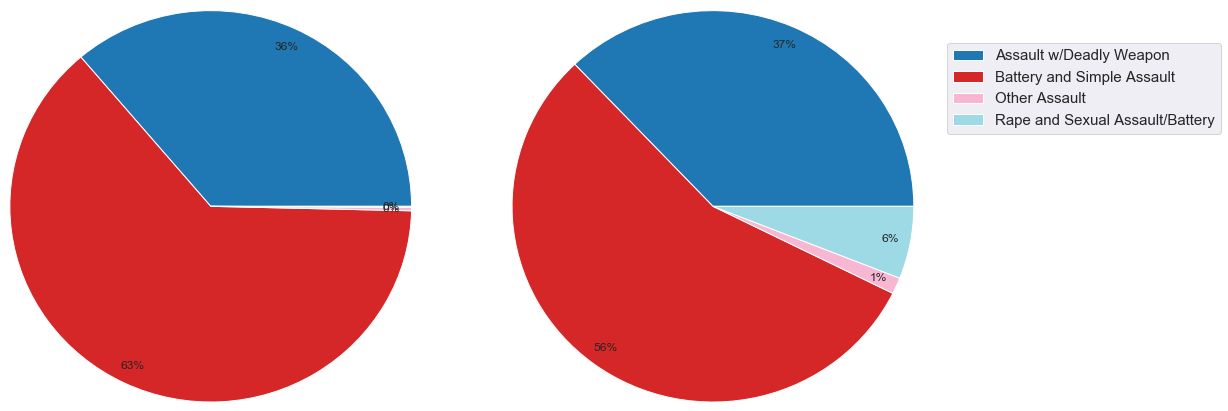

In [59]:
dcrime_hollenbeck=dcrime_by_district[(dcrime_by_district['Area Name']=='Hollenbeck') & (dcrime_by_district['Crime']=='Assault')]
dcrime_hollenbeck_before=dcrime_hollenbeck[dcrime_hollenbeck['Date Occurred']<2013]
dcrime_hollenbeck_after=dcrime_hollenbeck[dcrime_hollenbeck['Date Occurred']>=2013]
dcrime_hollenbeck_before=dcrime_hollenbeck_before.groupby(['Crime_Detailed']).size().to_frame('Count')
dcrime_hollenbeck_after=dcrime_hollenbeck_after.groupby(['Crime_Detailed']).size().to_frame('Count')
figs,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
dcrime_hollenbeck_after.plot.pie(ax=axes[1],y='Count',colormap='tab20',labels=None,autopct='%1.0f%%',pctdistance=.90, radius=1.5)
dcrime_hollenbeck_before.plot.pie(ax=axes[0],y='Count',colormap='tab20',labels=None,autopct='%1.0f%%',pctdistance=.90, radius=1.5,legend=False)
figs.subplots_adjust(wspace=.5)
axes[1].legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.,prop={'size':15},labels=dcrime_hollenbeck_after.index)

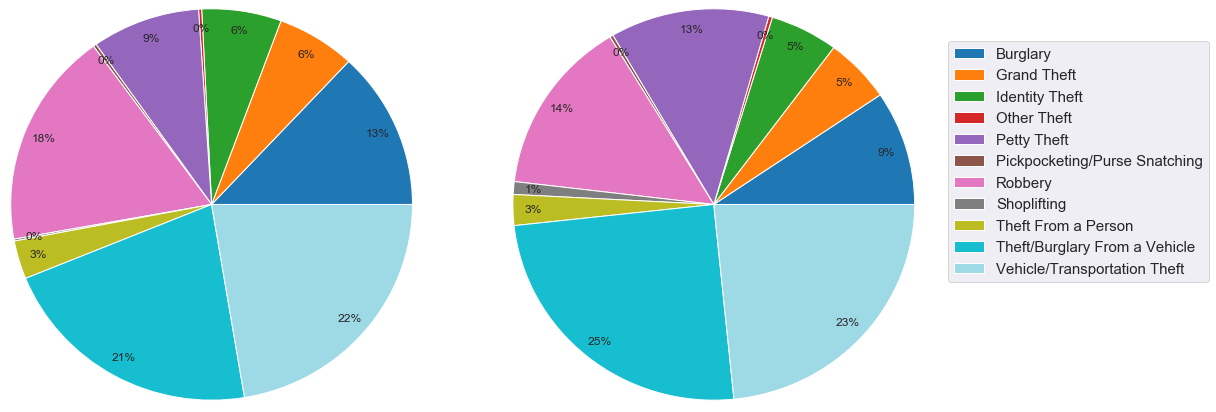

In [60]:
dcrime_newton=dcrime_by_district[(dcrime_by_district['Area Name']=='Newton') & (dcrime_by_district['Crime']=='Robbery and Theft')]
dcrime_newton_before=dcrime_newton[dcrime_newton['Date Occurred']<2013]
dcrime_newton_after=dcrime_newton[dcrime_newton['Date Occurred']>=2013]
dcrime_newton_before=dcrime_newton_before.groupby(['Crime_Detailed']).size().to_frame('Count')
dcrime_newton_after=dcrime_newton_after.groupby(['Crime_Detailed']).size().to_frame('Count')
figs,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
dcrime_newton_after.plot.pie(ax=axes[1],y='Count',colormap='tab20',labels=None,autopct='%1.0f%%',pctdistance=.90, radius=1.5)
dcrime_newton_before.plot.pie(ax=axes[0],y='Count',colormap='tab20',labels=None,autopct='%1.0f%%',pctdistance=.90, radius=1.5,legend=False)
figs.subplots_adjust(wspace=.5)
axes[1].legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.,prop={'size':15},labels=dcrime_newton_after.index)

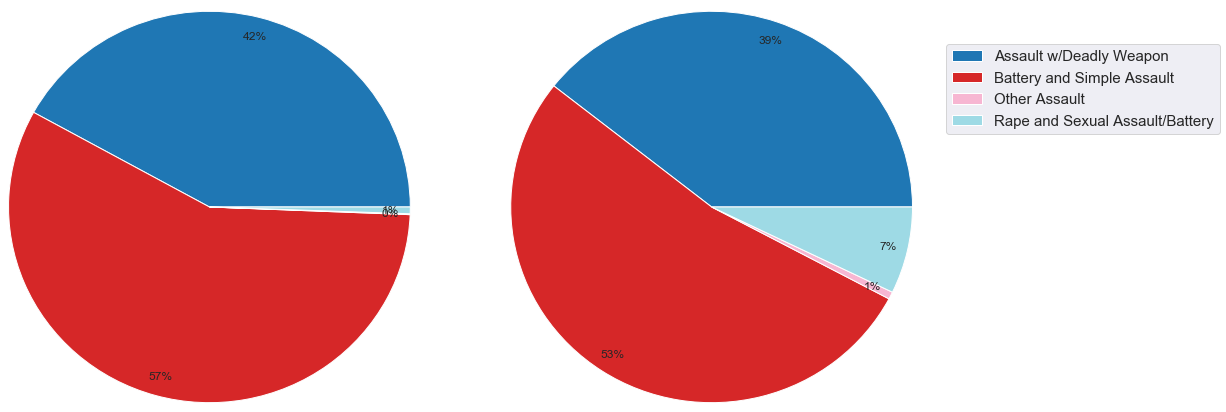

In [61]:
dcrime_newton=dcrime_by_district[(dcrime_by_district['Area Name']=='Newton') & (dcrime_by_district['Crime']=='Assault')]
dcrime_newton_before=dcrime_newton[dcrime_newton['Date Occurred']<2013]
dcrime_newton_after=dcrime_newton[dcrime_newton['Date Occurred']>=2013]
dcrime_newton_before=dcrime_newton_before.groupby(['Crime_Detailed']).size().to_frame('Count')
dcrime_newton_after=dcrime_newton_after.groupby(['Crime_Detailed']).size().to_frame('Count')
figs,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
dcrime_newton_after.plot.pie(ax=axes[1],y='Count',colormap='tab20',labels=None,autopct='%1.0f%%',pctdistance=.90, radius=1.5)
dcrime_newton_before.plot.pie(ax=axes[0],y='Count',colormap='tab20',labels=None,autopct='%1.0f%%',pctdistance=.90, radius=1.5,legend=False)
figs.subplots_adjust(wspace=.5)
axes[1].legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.,prop={'size':15},labels=dcrime_newton_after.index)

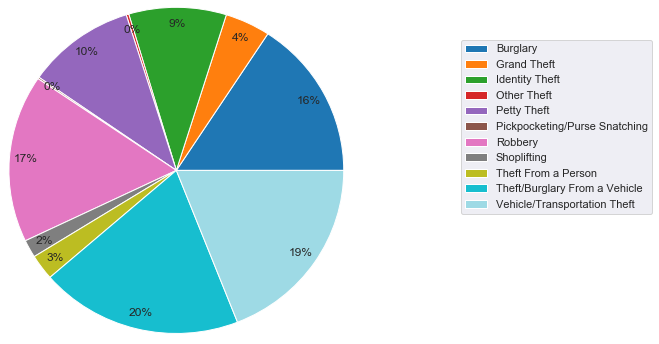

In [62]:
dcrime_77th=dcrime_by_district[(dcrime_by_district['Area Name']=='77th Street') & (dcrime_by_district['Crime']=='Robbery and Theft')]
dcrime_77th=dcrime_77th.groupby(['Crime_Detailed']).size().to_frame('Count')
dcrime_77th.plot.pie(y='Count',colormap='tab20',autopct='%1.0f%%',pctdistance=.90, radius=1.5,figsize=(5,5),labels=None)
plt.legend(bbox_to_anchor=(1.5,1),labels=dcrime_77th.index)

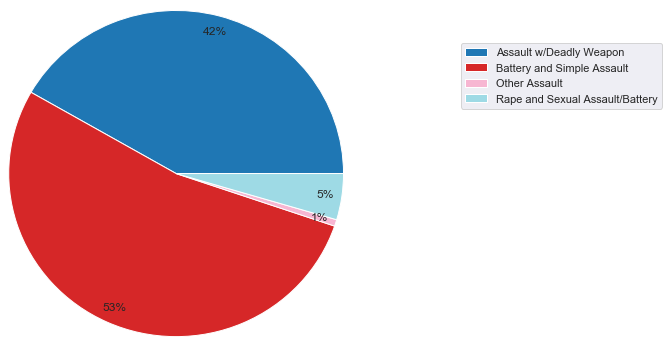

In [63]:
dcrime_77th=dcrime_by_district[(dcrime_by_district['Area Name']=='77th Street') & (dcrime_by_district['Crime']=='Assault')]
dcrime_77th=dcrime_77th.groupby(['Crime_Detailed']).size().to_frame('Count')
dcrime_77th.plot.pie(y='Count',colormap='tab20',autopct='%1.0f%%',pctdistance=.90, radius=1.5,figsize=(5,5),labels=None)
plt.legend(bbox_to_anchor=(1.5,1),labels=dcrime_77th.index)

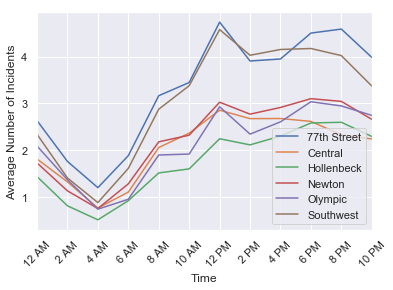

In [64]:
crime_time=df.loc[:,['Date Occurred_Time Occurred','Area Name','Crime Code Description']]
crime_time_rising=crime_time[(crime_time['Area Name']=='Central')| (crime_time['Area Name']=='Olympic')|(crime_time['Area Name']=='Newton') | (crime_time['Area Name']=='Hollenbeck')|(crime_time['Area Name']=='77th Street')|(crime_time['Area Name']=='Southwest')]
crime_time_rising.set_index(['Date Occurred_Time Occurred'],inplace=True)
crime_time_rising=crime_time_rising.groupby('Area Name')
crime_time_rising=crime_time_rising.resample('2H').count()
crime_time_rising.drop(columns='Area Name',inplace=True)
crime_time_rising.reset_index(inplace=True)
crime_time_rising['Time Occurred']=crime_time_rising['Date Occurred_Time Occurred'].dt.time
crime_time_rising.drop(columns='Date Occurred_Time Occurred',inplace=True)
crime_time_rising=crime_time_rising.groupby(['Time Occurred','Area Name'])['Crime Code Description'].mean().to_frame('Average')
crime_time_rising=crime_time_rising.unstack(level='Area Name')
crime_time_rising.plot()
ax=plt.gca() 
ax.set_xticks(crime_time_rising.index)
plt.xlim(crime_time_rising.index[0],crime_time_rising.index[-1])
ax.set_xticklabels(['12 AM','2 AM','4 AM','6 AM','8 AM','10 AM','12 PM','2 PM','4 PM','6 PM','8 PM','10 PM'],rotation=45)
plt.xlabel('Time')
plt.ylabel('Average Number of Incidents')
plt.legend(loc='lower right',labels=['77th Street','Central','Hollenbeck','Newton','Olympic','Southwest'])

H          622877
W          441442
B          287847
O          174304
Missing    166297
X           54197
A           42766
K            7999
F            2102
I             747
C             684
P             305
J             267
U             166
V             102
G              72
Z              66
S              28
D              18
L              11
-               2
Name: Victim Descent, dtype: int64


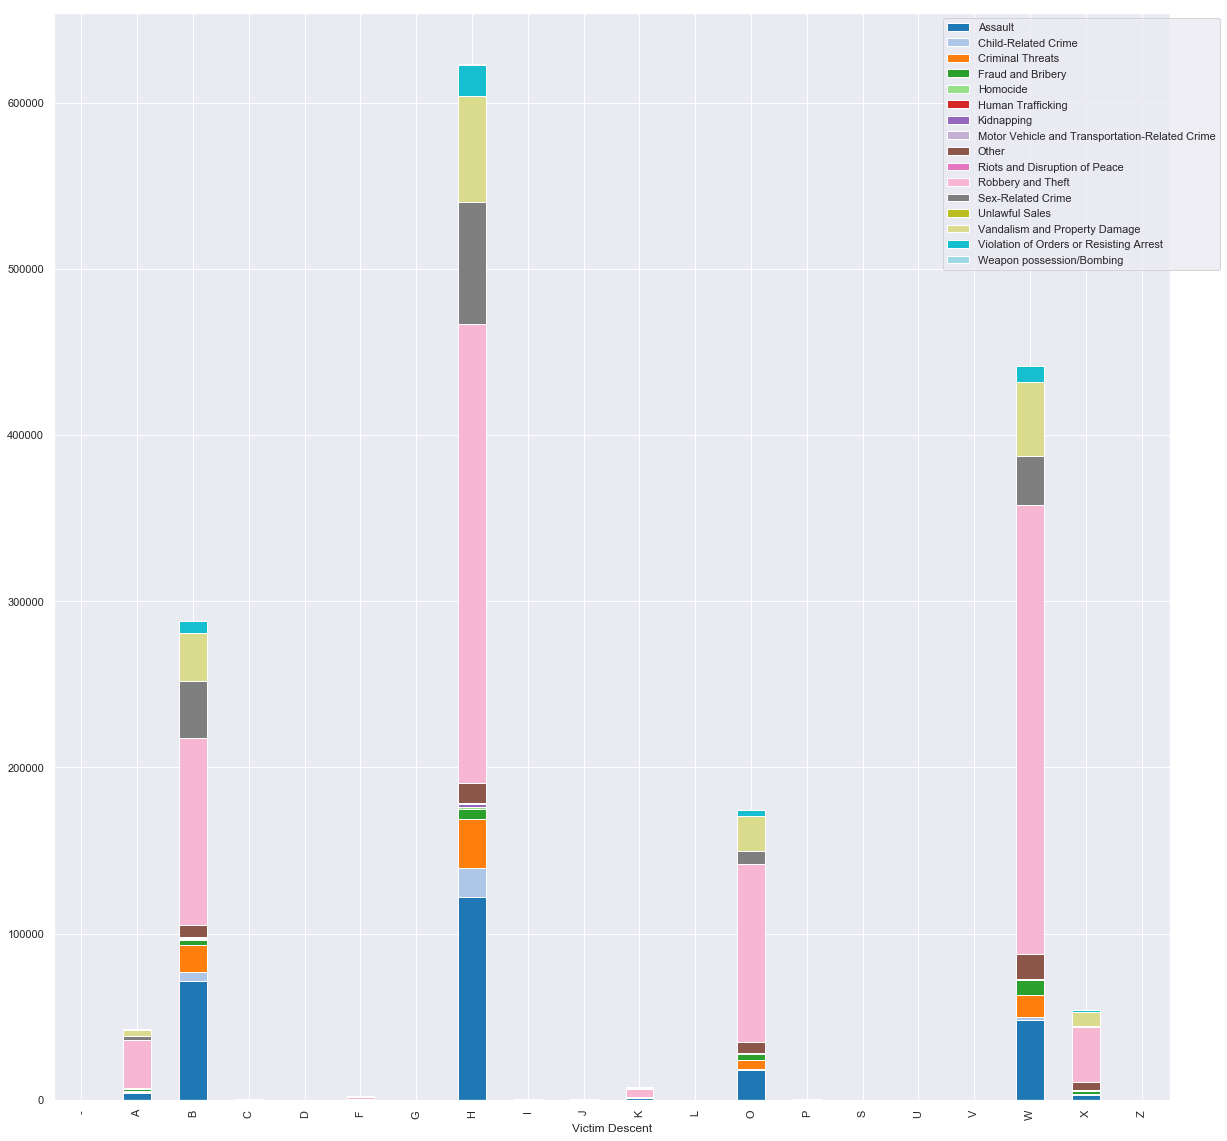

In [65]:
descent_crime=df.loc[:,['Victim Descent','Crime']]
print(descent_crime['Victim Descent'].value_counts())
descent_crime=descent_crime[descent_crime['Victim Descent']!='Missing']
descent_crime=descent_crime.groupby(['Victim Descent','Crime']).size().to_frame('Count')
descent_crime=descent_crime.unstack(level='Crime',fill_value=0)
descent_crime['Count'].plot(kind='bar',stacked=True,colormap='tab20',figsize=(20,20))
plt.legend(bbox_to_anchor=(1.05,1))

In [66]:
df_null=(df['Victim Age']=='Missing')|(df['Victim Sex']=='Missing') | (df['Victim Descent']=='Missing')
df_clean=df[~df_null]
df_clean.head()

Date Occurred_Time Occurred    Area Name  \
0          2013-03-11 18:00:00  77th Street   
4          2014-01-04 23:00:00      Topanga   
5          2013-01-08 14:00:00      Central   
9          2013-01-15 08:00:00     Van Nuys   
12         2013-02-13 12:00:00  77th Street   

                        Crime Code Description Victim Age Victim Sex  \
0            INTIMATE PARTNER - SIMPLE ASSAULT         30          F   
4     VANDALISM - MISDEAMEANOR ($399 OR UNDER)         84          M   
5                            CRIMINAL HOMICIDE         49          F   
9   EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)         27          F   
12          THEFT PLAIN - PETTY ($950 & UNDER)         42          M   

   Victim Descent     Premise Description Status Description  \
0               W     MULTI-UNIT DWELLING        Adult Other   
4               W  SINGLE FAMILY DWELLING        Invest Cont   
5               W  SINGLE FAMILY DWELLING       Adult Arrest   
9               O          OTHER BUSINESS        Invest Cont   
12              H             PARKING LOT        Invest Cont   

               Location  Date Occurred               ...                 \
0   (33.9829, -118.3338)    2013-03-11               ...                  
4   (34.2009, -118.6369)    2014-01-04               ...                  
5   (34.0591, -118.2412)    2013-01-08               ...                  
9   (34.2012, -118.4662)    2013-01-15               ...                  
12  (33.9651, -118.2783)    2013-02-13               ...                  

        Hour_cos  Min_sin  Min_cos   Day_sin   Day_cos  Month_sin  \
0  -1.836970e-16      0.0      1.0  0.790776 -0.612106  -0.500000   
4   9.659258e-01      0.0      1.0  0.724793  0.688967   0.866025   
5  -8.660254e-01      0.0      1.0  0.998717 -0.050649  -0.866025   
9  -5.000000e-01      0.0      1.0  0.101168 -0.994869   1.000000   
12 -1.000000e+00      0.0      1.0  0.485302 -0.874347   0.500000   

       Month_cos  Time Code                          Crime  \
0   8.660254e-01    Evening              Sex-Related Crime   
4  -5.000000e-01      Night  Vandalism and Property Damage   
5  -5.000000e-01  Afternoon                       Homocide   
9   1.194340e-15    Morning              Robbery and Theft   
12  8.660254e-01    Morning              Robbery and Theft   

                     Crime_Detailed  
0   Rape and Sexual Assault/Battery  
4     Vandalism and Property Damage  
5                          Homocide  
9                       Grand Theft  
12                      Petty Theft  

[5 rows x 26 columns]

In [67]:
df_clean['Victim Age']=pd.to_numeric(df_clean['Victim Age'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [68]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1512921 entries, 0 to 1805536
Data columns (total 26 columns):
Date Occurred_Time Occurred    1512921 non-null datetime64[ns]
Area Name                      1512921 non-null object
Crime Code Description         1512921 non-null object
Victim Age                     1512921 non-null float64
Victim Sex                     1512921 non-null object
Victim Descent                 1512921 non-null object
Premise Description            1512921 non-null object
Status Description             1512921 non-null object
Location                       1512921 non-null object
Date Occurred                  1512921 non-null object
Time Occurred                  1512921 non-null object
Hour                           1512921 non-null int64
Minute                         1512921 non-null int64
Day_of_Month                   1512921 non-null int64
Month                          1512921 non-null int64
Hour_sin                       1512921 non-null float64
H

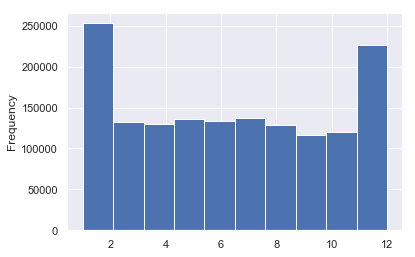

In [69]:
df_clean['Date Occurred_Time Occurred'].dt.month.plot(kind='hist')

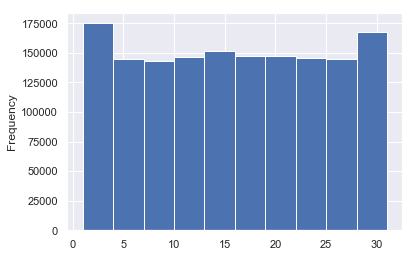

In [70]:
df_clean['Day_of_Month'].plot(kind='hist')

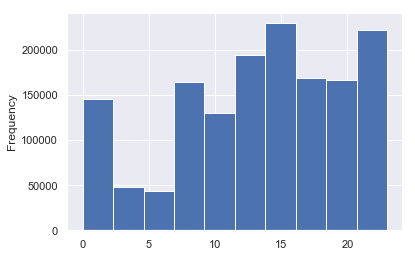

In [71]:
df_clean['Hour'].plot(kind='hist')

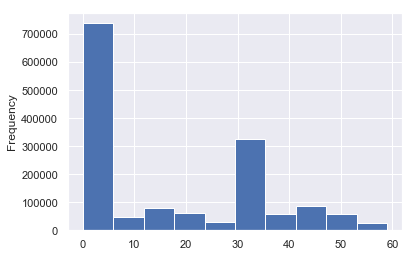

In [72]:
df_clean['Minute'].plot(kind='hist')

Text(0,0.5,'Crime Count')

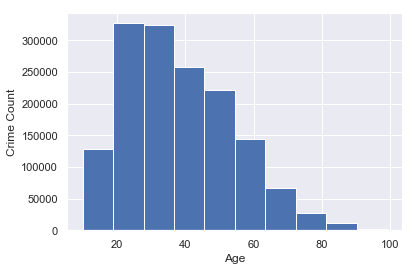

In [73]:
df_clean['Victim Age'].plot(kind='hist')
plt.xlabel('Age')
plt.ylabel('Crime Count')

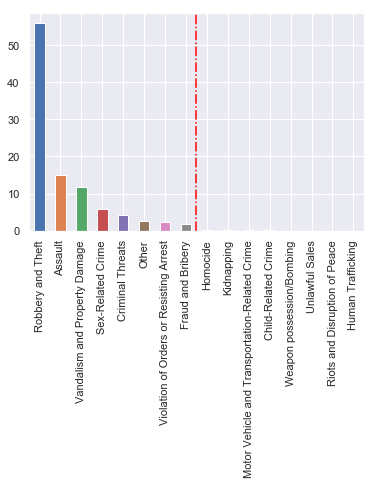

In [74]:
df_age_high=df_clean[df_clean['Victim Age']>40]
age_high_crime_count=((df_age_high['Crime'].value_counts()/(df_age_high['Crime'].value_counts().sum())))*100
age_high_crime_count.plot(kind='bar')
plt.axvline(7.5,color='red',linestyle='-.')

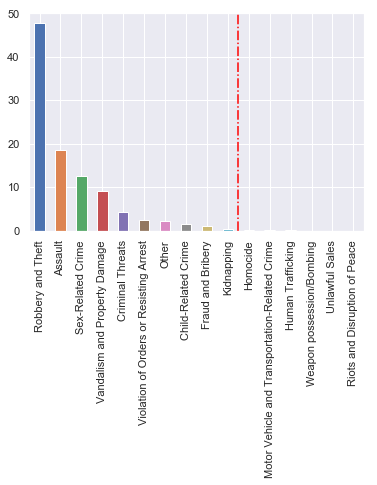

In [75]:
df_age_low=df_clean[df_clean['Victim Age']<40]
age_low_crime_count=((df_age_low['Crime'].value_counts()/(df_age_low['Crime'].value_counts().sum())))*100
age_low_crime_count.plot(kind='bar')
plt.axvline(9.5,color='red',linestyle='-.')

In [76]:
df_clean['Victim Sex'].value_counts()

M    753474
F    747712
X     11668
H        61
N         5
-         1
Name: Victim Sex, dtype: int64

Text(0,0.5,'Crime Count')

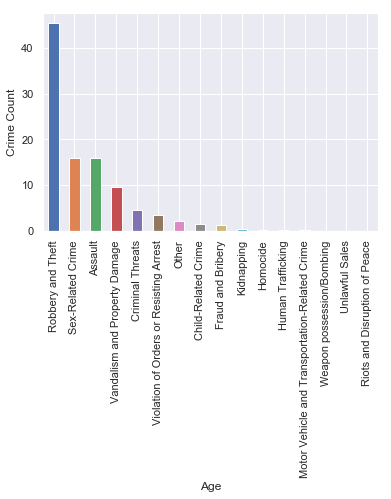

In [77]:
df_sex_female=df_clean[df_clean['Victim Sex']=='F']
((df_sex_female['Crime'].value_counts())/(df_sex_female['Crime'].value_counts().sum())*100).plot(kind='bar')
plt.xlabel('Age')
plt.ylabel('Crime Count')

Text(0,0.5,'Crime Count')

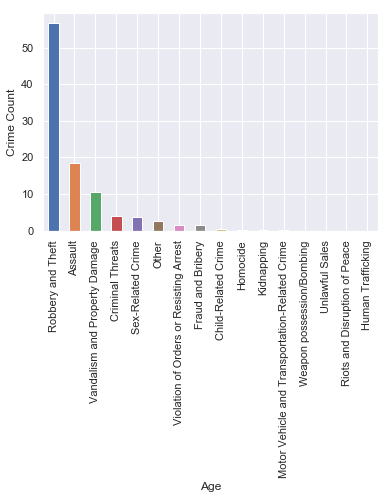

In [78]:
df_sex_male=df_clean[df_clean['Victim Sex']=='M']
((df_sex_male['Crime'].value_counts())/(df_sex_male['Crime'].value_counts().sum())*100).plot(kind='bar')
plt.xlabel('Age')
plt.ylabel('Crime Count')

Text(0,0.5,'Crime Count')

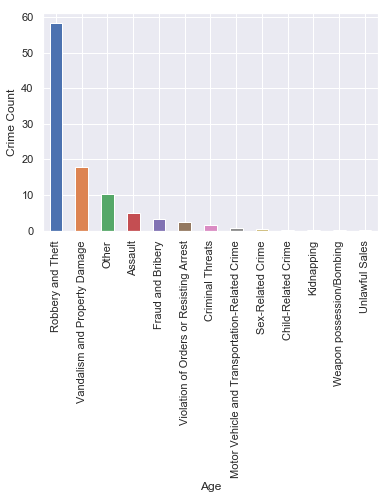

In [79]:
df_sex_x=df_clean[df_clean['Victim Sex']=='X']
count=(((df_sex_x['Crime'].value_counts())/(df_sex_x['Crime'].value_counts().sum())*100))
count.plot(kind='bar')
plt.xlabel('Age')
plt.ylabel('Crime Count')

Text(0,0.5,'Crime Count')

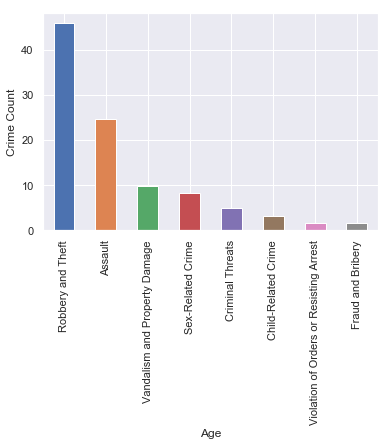

In [80]:
df_sex_h=df_clean[df_clean['Victim Sex']=='H']
((df_sex_h['Crime'].value_counts())/(df_sex_h['Crime'].value_counts().sum())*100).plot(kind='bar')
plt.xlabel('Age')
plt.ylabel('Crime Count')

In [81]:
df_clean.loc[:,'Location ']=df_clean.loc[:,'Location '].str.strip('(')
df_clean.loc[:,'Location ']=df_clean.loc[:,'Location '].str.strip(')')

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [82]:
df_clean['Location ']=df_clean['Location '].str.split(',')
df_clean['Latitude']=df_clean['Location '].apply(lambda x: x[0])
df_clean['Longitude']=df_clean['Location '].apply(lambda x: x[1])
df_clean[['Latitude','Longitude']]=df_clean[['Latitude','Longitude']].astype(float)
df_clean=(df_clean[~(df_clean['Longitude']==0)| ~(df_clean['Latitude']==0)])
df_clean[['Victim Sex','Victim Descent','Premise Description']]=df_clean[['Victim Sex','Victim Descent','Premise Description']].apply(lambda x : x.astype('category'))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

### Machine Learning 

In [83]:
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA 
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, accuracy_score 
from keras.layers import Dense 
from keras.models import Sequential 
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras.optimizers import Adadelta

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<BarContainer object of 11 artists>

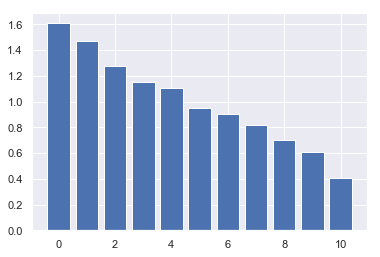

In [84]:
X_pca=df_clean[['Victim Age','Month_sin','Month_cos','Min_sin','Min_cos','Day_sin','Day_cos','Hour_sin','Hour_cos','Latitude','Longitude']].values
pca=PCA()
pipeline=make_pipeline(StandardScaler(),pca) 
pipeline.fit(X_pca)
plt.bar(range(pca.n_components_),pca.explained_variance_)

In [85]:
df_clean_full=df_clean[['Month_sin','Month_cos','Min_sin','Min_cos','Crime','Hour_sin','Hour_cos','Latitude','Longitude','Victim Age','Victim Sex','Victim Descent','Area Name']].copy()
df_clean_full=df_clean[(df_clean['Area Name']=='Olympic')|(df_clean['Area Name']=='Central')|(df_clean['Area Name']=='Newton')|(df_clean['Area Name']=='Hollenbeck')|(df_clean['Area Name']=='Hollywood')]
df_clean_full=df_clean_full[(df_clean_full['Crime']=='Assault')|(df_clean_full['Crime']=='Robbery and Theft')]
df_clean_full_y=df_clean_full[['Crime']]
df_clean_full=pd.get_dummies(df_clean_full[['Month_sin','Month_cos','Latitude','Longitude','Min_sin','Min_cos','Victim Descent','Victim Age','Hour_sin','Hour_cos','Victim Sex']])

In [86]:
df_clean_full=pd.concat([df_clean_full_y,df_clean_full],axis=1)
def dummy_creator(data):
    if data==('Assault'): 
        return 1
    else: 
        return 0 
    
df_clean_full['Crime']=df_clean_full['Crime'].apply(dummy_creator)

In [87]:
df_clean_full.head()

Crime     Month_sin  Month_cos  Latitude  Longitude       Min_sin  \
16      1  8.660254e-01   0.500000   34.0431  -118.2536 -1.959435e-15   
18      1  8.660254e-01   0.500000   34.0352  -118.2583  0.000000e+00   
19      0  8.660254e-01  -0.500000   34.0480  -118.2577 -1.715001e-14   
23      1  5.000000e-01  -0.866025   34.0517  -118.2456 -9.797174e-16   
24      1  1.224647e-16  -1.000000   34.0435  -118.2471 -8.575004e-15   

    Min_cos  Victim Age  Hour_sin  Hour_cos      ...       Victim Descent_V  \
16      1.0        23.0 -0.500000 -0.866025      ...                      0   
18      1.0        18.0 -0.707107 -0.707107      ...                      0   
19      1.0        25.0 -0.965926 -0.258819      ...                      0   
23      1.0        20.0 -0.866025  0.500000      ...                      0   
24      1.0        32.0 -0.258819  0.965926      ...                      0   

    Victim Descent_W  Victim Descent_X  Victim Descent_Z  Victim Sex_-  \
16                 0                 0                 0             0   
18                 0                 0                 0             0   
19                 0                 0                 0             0   
23                 0                 0                 0             0   
24                 0                 0                 0             0   

    Victim Sex_F  Victim Sex_H  Victim Sex_M  Victim Sex_N  Victim Sex_X  
16             0             0             1             0             0  
18             1             0             0             0             0  
19             0             0             1             0             0  
23             1             0             0             0             0  
24             1             0             0             0             0  

[5 rows x 36 columns]

In [88]:
df_clean_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219521 entries, 16 to 1805284
Data columns (total 36 columns):
Crime               219521 non-null int64
Month_sin           219521 non-null float64
Month_cos           219521 non-null float64
Latitude            219521 non-null float64
Longitude           219521 non-null float64
Min_sin             219521 non-null float64
Min_cos             219521 non-null float64
Victim Age          219521 non-null float64
Hour_sin            219521 non-null float64
Hour_cos            219521 non-null float64
Victim Descent_-    219521 non-null uint8
Victim Descent_A    219521 non-null uint8
Victim Descent_B    219521 non-null uint8
Victim Descent_C    219521 non-null uint8
Victim Descent_D    219521 non-null uint8
Victim Descent_F    219521 non-null uint8
Victim Descent_G    219521 non-null uint8
Victim Descent_H    219521 non-null uint8
Victim Descent_I    219521 non-null uint8
Victim Descent_J    219521 non-null uint8
Victim Descent_K    219521 no

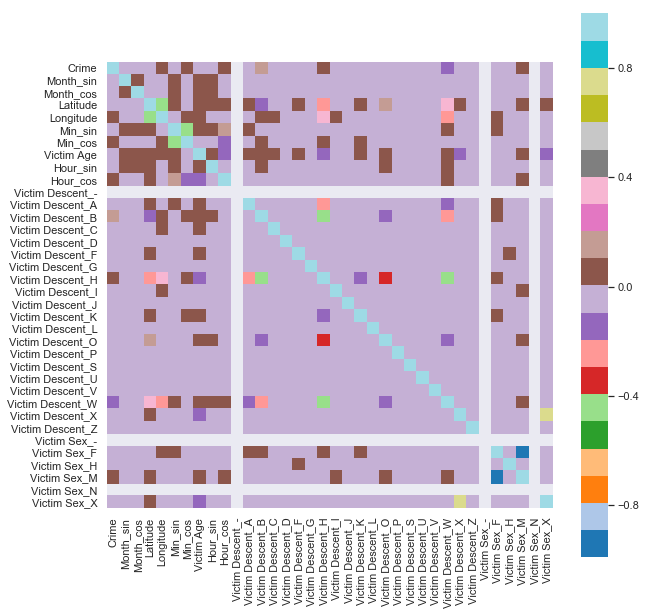

In [89]:
plt.figure(figsize=(10,10))
ax=sns.heatmap(df_clean_full.corr(),square=True,cmap='tab20') 

In [90]:
X_mod=df_clean_full.drop(columns='Crime').values
Y_mod=df_clean_full['Crime'].values 
print(X_mod.shape)
print(Y_mod.shape)


(219521, 35)
(219521,)


In [91]:
X_train,X_test,y_train,y_test = train_test_split(X_mod,Y_mod,test_size=.5, random_state=42,stratify=Y_mod)

In [92]:
# dct=DecisionTreeClassifier()
# param_grid={'class_weight':[None,'balanced'],'class_weight':['balanced',None],'max_features':['auto',None]}
# gs_dct=GridSearchCV(dct,param_grid=param_grid)
# gs_dct.fit(X_train,y_train)
# print(gs_dct.best_params_) 
# gs_dct.score(X_test,y_test)

# {'class_weight': None, 'max_depth': 10, 'max_features': None}

# score : 0.7572853491638042

In [93]:
# etc=ExtraTreesClassifier(n_estimators=40)
# etc.fit(X_train,y_train)
# print(etc.score(X_test,y_test))

In [94]:
# mlp=MLPClassifier()
# param_grid={'alpha':[.0001,.01,1,100]}
# gs_mlp=GridSearchCV(mlp,param_grid=param_grid,scoring='roc_auc')
# gs_mlp.fit(X_train,y_train)
# gs_mlp.best_params_
# gs_mlp.best 
# print(gs_mlp.score(X_test,y_test))

In [95]:
# abc=AdaBoostClassifier()
# learning_rate=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0]
# param_grid={'learning_rate':learning_rate,'n_estimators':[100,130,150]}
# gs=GridSearchCV(abc,param_grid=param_grid,scoring='roc_auc')
# gs.fit(X_train,y_train)
# gs.best_params_

# best_params_ --> learning_rate=1.0, n_estimators=150 

In [96]:
# default learning rate for AdaBoostClassifier is 1 and default n_estimators 100  
# leads to the same score
# default values will be kept 
# Next steps: try out different base_estimators

In [97]:
# abc=AdaBoostClassifier(n_estimators=40,learning_rate=.3)
# abc.fit(X_train,y_train)
# abc.score(X_test,y_test)

In [98]:
# pipe=Pipeline([('scaler',StandardScaler()),('clf', AdaBoostClassifier(n_estimators=40))])
# param_grid=[{'clf__base_estimator': (ExtraTreesClassifier(n_estimators=40),RandomForestClassifier(n_estimators=40))}]
# gs2=GridSearchCV(pipe,param_grid)
# gs2.fit(X_train,y_train)
# gs2.best_params_
# gs2.score(X_test,y_test)

# best params_ --> RandomForestClassifier() 

In [99]:
# xgb=XGBClassifier()
# param_grid={'n_estimators':[50,150],'max_depth':[5,10]}
# xgb=GridSearchCV(xgb,param_grid=param_grid,cv=5)
# xgb.fit(X_train,y_train)
# xgb.best_params_ 

# Best parameters n_estimators: 150, max_depth: 10 

In [100]:
xgb=XGBClassifier(n_estimators=150,max_depth=10)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [101]:
# Accuracy Score 
xgb.score(X_test,y_test)

0.7226428330645676

In [102]:
# ROC/AUC score 
y_pred_proba=xgb.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred_proba)

0.7402154245815713

Text(0.5,1,'ROC curve')

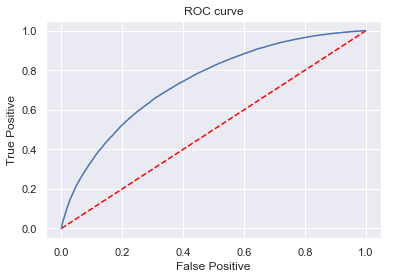

In [103]:
fpr,tpr,thresholds=roc_curve(y_test,y_pred_proba)
plt.plot([0,1],[0,1],'k--',color='red')
plt.plot(fpr,tpr)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC curve')

In [104]:
y_pred=xgb.predict(X_test)
xgb_df=pd.DataFrame({'true':y_test,'predicted':y_pred})
pd.crosstab(xgb_df['true'],xgb_df['predicted'])

predicted      0      1
true                   
0          66393   8368
1          22075  12925

In [105]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.89      0.81     74761
           1       0.61      0.37      0.46     35000

   micro avg       0.72      0.72      0.72    109761
   macro avg       0.68      0.63      0.64    109761
weighted avg       0.70      0.72      0.70    109761



In [106]:
# # Stacking multiple classifiers?
# models=[XGBClassifier(max_depth=10,n_estimators=40,eta=.3,subsample=.8),GradientBoostingClassifier(max_depth=10,n_estimators=40, subsample=.8)]
# blending_model=LogisticRegression()
# sg=StackingClassifier(models,blending_model)
# pipe_sg=make_pipeline(sg) 
# pipe_sg.fit(X_train,y_train)
# pipe_sg.score(X_test,y_test)

# YELDS A WIERD ROC curve 

In [107]:
majority=df_clean_full[df_clean_full['Crime']==0]
minority=df_clean_full[df_clean_full['Crime']==1]
print('majority', len(majority))
print('minority',len(minority))


majority 149521
minority 70000


In [108]:
minority_upscale=resample(majority,replace=False,n_samples=len(minority),random_state=42)

In [109]:
scaled_df=pd.concat([minority,minority_upscale])

In [110]:
X_scaled=scaled_df.drop(columns='Crime').values
Y_scaled=scaled_df['Crime'].values 

In [111]:
X_train_s,X_test_s,y_train_s,y_test_s = train_test_split(X_scaled,Y_scaled,test_size=.3, random_state=42,stratify=Y_scaled)

In [112]:
xgb_s=XGBClassifier(n_estimators=40,max_depth=10,eta=.3,subsample=.8)
xgb_s.fit(X_train_s,y_train_s)
xgb_s.score(X_test_s,y_test_s)
y_pred_s=xgb_s.predict(X_test_s)

In [113]:
# Accuracy Score 
xgb_s.score(X_test_s,y_test_s)

0.6727619047619048

In [114]:
# Classification Report 
print(classification_report(y_test_s,y_pred_s))

              precision    recall  f1-score   support

           0       0.68      0.65      0.66     21000
           1       0.66      0.70      0.68     21000

   micro avg       0.67      0.67      0.67     42000
   macro avg       0.67      0.67      0.67     42000
weighted avg       0.67      0.67      0.67     42000



In [115]:
# ROC/AUC score 
y_pred_proba_s=xgb_s.predict_proba(X_test_s)[:,1]
roc_auc_score(y_test_s,y_pred_proba_s)

0.7364026621315193

Text(0.5,1,'ROC curve')

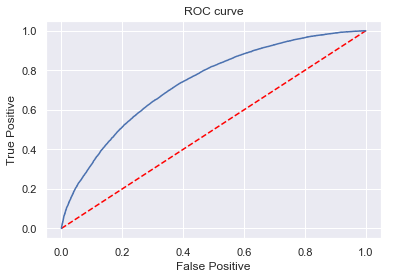

In [116]:
# ROC curve 
fpr,tpr,thresholds=roc_curve(y_test_s,y_pred_proba_s)
plt.plot([0,1],[0,1],'k--',color='red')
plt.plot(fpr,tpr)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC curve')

In [117]:
# Confusion Matrix 
xgb_df_s=pd.DataFrame({'true':y_test_s,'predicted':y_pred_s})
pd.crosstab(xgb_df_s['true'],xgb_df_s['predicted'])

predicted      0      1
true                   
0          13610   7390
1           6354  14646

### Deep Learning 

In [118]:
def dummy_creator_2(data):
    if data==0: 
        return 1
    else: 
        return 0 
    
df_clean_full['Crime_0']=df_clean_full['Crime'].apply(dummy_creator_2)

In [119]:
df_clean_full.head()

Crime     Month_sin  Month_cos  Latitude  Longitude       Min_sin  \
16      1  8.660254e-01   0.500000   34.0431  -118.2536 -1.959435e-15   
18      1  8.660254e-01   0.500000   34.0352  -118.2583  0.000000e+00   
19      0  8.660254e-01  -0.500000   34.0480  -118.2577 -1.715001e-14   
23      1  5.000000e-01  -0.866025   34.0517  -118.2456 -9.797174e-16   
24      1  1.224647e-16  -1.000000   34.0435  -118.2471 -8.575004e-15   

    Min_cos  Victim Age  Hour_sin  Hour_cos   ...     Victim Descent_W  \
16      1.0        23.0 -0.500000 -0.866025   ...                    0   
18      1.0        18.0 -0.707107 -0.707107   ...                    0   
19      1.0        25.0 -0.965926 -0.258819   ...                    0   
23      1.0        20.0 -0.866025  0.500000   ...                    0   
24      1.0        32.0 -0.258819  0.965926   ...                    0   

    Victim Descent_X  Victim Descent_Z  Victim Sex_-  Victim Sex_F  \
16                 0                 0             0             0   
18                 0                 0             0             1   
19                 0                 0             0             0   
23                 0                 0             0             1   
24                 0                 0             0             1   

    Victim Sex_H  Victim Sex_M  Victim Sex_N  Victim Sex_X  Crime_0  
16             0             1             0             0        0  
18             0             0             0             0        0  
19             0             1             0             0        1  
23             0             0             0             0        0  
24             0             0             0             0        0  

[5 rows x 37 columns]

In [120]:
X_mod_deep=df_clean_full.drop(columns=['Crime','Crime_0']).values
Y_mod_deep=df_clean_full[['Crime','Crime_0']].values 
print(X_mod_deep.shape)
print(Y_mod_deep.shape)

(219521, 35)
(219521, 2)


In [121]:
X_train_deep,X_test_deep,y_train_deep,y_test_deep = train_test_split(X_mod_deep,Y_mod_deep,test_size=.3, random_state=42,stratify=Y_mod)

In [122]:
n_cols=X_train.shape[1]
deep_model1=Sequential()
deep_model1.add(Dense(100,activation='relu',input_shape=(n_cols,)))
deep_model1.add(Dense(400,activation='relu'))


In [123]:
deep_model1.add(Dense(2,activation='softmax'))
deep_model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [125]:
early_stopping_monitor = EarlyStopping(patience=2)
deep_model1.fit(X_train_deep,y_train_deep,validation_split=.3,epochs=20,callbacks=[early_stopping_monitor])
predictions=deep_model.predict(X_test_deep)

Train on 107564 samples, validate on 46100 samples
Epoch 1/20
107564/107564 [==============================] - 6s 60us/step - loss: 0.6424 - acc: 0.6624 - val_loss: 0.6017 - val_acc: 0.6803
Epoch 2/20
107564/107564 [==============================] - 8s 74us/step - loss: 0.6047 - acc: 0.6789 - val_loss: 0.6067 - val_acc: 0.6783
Epoch 3/20
107564/107564 [==============================] - 9s 80us/step - loss: 0.6018 - acc: 0.6807 - val_loss: 0.6016 - val_acc: 0.6810
Epoch 4/20
107564/107564 [==============================] - 8s 74us/step - loss: 0.6002 - acc: 0.6820 - val_loss: 0.6000 - val_acc: 0.6832
Epoch 5/20
107564/107564 [==============================] - 6s 60us/step - loss: 0.5987 - acc: 0.6831 - val_loss: 0.6028 - val_acc: 0.6810
Epoch 6/20
107564/107564 [==============================] - 7s 64us/step - loss: 0.5981 - acc: 0.6836 - val_loss: 0.6019 - val_acc: 0.6839


NameError: name 'deep_model' is not defined